In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import tensorflow as tf
import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.regularizers import l2
# Evaluation (Metrics & DM-Test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import islice
from math import lgamma, fabs, isnan, nan, exp, log, log1p, sqrt
from typing import Sequence, Callable, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

#### **1. Data Preparation**

In [2]:
df = pd.read_csv("df_ff_factors_100325.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')
df

df_tech = pd.read_csv("df_ff_factors_techfunds.csv")
df_tech = df_tech.drop(columns=["Unnamed: 0","crsp_portno"])
df_tech = df_tech.sort_values(by='date')

In [3]:
df_tech

,crsp_fundno,date,mth_return,exp_ratio,turn_ratio,normalised_flow,gdp_to_debt_ratio,gdp_growth_rate,unm_rate,infl_rate,...,cma,rf,umd,excess_return,rolling_sharpe,mkt_return,rolling_alpha_3f,rolling_alpha_4f,rolling_alpha_5f,shortrun_momentum
43631,32553.0,1993-08-31,0.068935,0.0162,0.15,0.009529,64.101,3.5225,6.8,2.90,...,-0.0004,0.0025,0.0265,0.068910,3.248937,0.056070,0.068910,0.068910,0.068910,0.012866
43632,32553.0,1993-09-30,-0.004082,0.0162,0.15,0.014881,64.101,3.5225,6.7,2.90,...,-0.0016,0.0026,0.0337,-0.004108,2.216452,0.027009,-0.004108,-0.004108,-0.004108,-0.009113
43633,32553.0,1993-10-29,0.040984,0.0162,0.15,0.030641,64.669,3.5225,6.8,2.90,...,0.0060,0.0022,-0.0272,0.040962,3.058133,0.021609,0.040962,0.040962,0.040962,0.000383
13747,12051.0,1993-10-29,0.034712,0.0188,0.77,0.070030,64.669,3.5225,6.8,2.90,...,0.0060,0.0022,-0.0272,0.034690,5.744340,0.021609,0.034690,0.034690,0.034690,0.013103
13748,12051.0,1993-11-30,-0.075974,0.0188,0.77,0.000259,64.669,3.5225,6.6,2.90,...,-0.0094,0.0025,-0.0474,-0.075999,-0.536935,-0.010806,-0.075999,-0.075999,-0.075999,-0.026033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,4610.0,2024-06-28,0.078565,0.0217,0.23,-0.650182,120.040,2.5427,4.1,3.35,...,-0.0102,0.0047,0.0508,0.078518,1.619481,0.055058,0.001428,0.002329,0.003201,-0.025985
1960,4330.0,2024-07-31,0.028831,0.0077,0.31,-0.022800,120.731,2.5427,4.2,3.35,...,-0.0102,0.0047,0.0508,0.028784,0.691406,0.055058,0.004765,0.005643,0.010978,-0.024241
2113,4333.0,2024-07-31,0.028826,0.0076,0.31,-0.402964,120.731,2.5427,4.2,3.35,...,-0.0102,0.0047,0.0508,0.028779,0.691738,0.055058,0.004733,0.005601,0.010953,-0.024228
1842,4327.0,2024-07-31,0.028616,0.0102,0.31,-0.032107,120.731,2.5427,4.2,3.35,...,-0.0102,0.0047,0.0508,0.028569,0.676394,0.055058,0.004506,0.005384,0.010697,-0.024451


The chunk below describes the various functions involved in the training of the models, which are described in greater depth below:

(1) Generation of lagged dataframe i.e. lagging the characteristics

(2) Generation of stepped dataframe i.e. lagged characteristics being together with the 1-month ahead forecast

(3) Demeaning function for fund-level characteristics, which is important to ensure accuracy in the overall forecasting of annualised alphas

In [4]:
# Generate Lagged Dataset
def create_lagged_dataset(dataset, lag, target_var, id):
    lagged_dataset = dataset.copy()
    columns_list = list(lagged_dataset.columns)
    data_join = {}
    for column in columns_list:
        if column == target_var:
            data_join[column] = lagged_dataset[column]
        for n in range(1,lag+1):
            data_join[F'{column}_L{n}'] = lagged_dataset.groupby(id)[column].shift(n)
    lagged_dataset = pd.concat(data_join.values(), axis=1, ignore_index = True)
    lagged_dataset.columns = data_join.keys()
    return lagged_dataset.dropna()

# Generate Stepped Dataset for Training
## Steps is the number of months ahead that we are forecasting, e.g. step=2 is 2 months ahead.
## Note step=1 results in no change to dataset, i.e. use generated lagged variables to forecast current. 
def create_stepped_dataset(dataset, step, target_var, id):
    
    shifted_dataset = dataset.copy()
    shifted_dataset['shifted_target'] = shifted_dataset.groupby(id)[target_var].shift(-step + 1)
    
    # Drop rows where the shifted target is NaN (these occur due to the shift operation)
    shifted_dataset = shifted_dataset.dropna(subset=['shifted_target'])
    
    # Separate the features (X) and the target (y)
    X = shifted_dataset.drop(columns=[target_var, 'shifted_target'])
    y = shifted_dataset[['shifted_target']]
    y = y.rename(columns={'shifted_target':target_var})
    return X, y

def demeaning_fund_char(dataset, id, characteristic):
    for col in characteristic:
        dataset[f'demeaned_{col}'] = dataset[col] - dataset.groupby(id)[col].transform('mean')
    return dataset

In [5]:
import pandas as pd

# Assuming 'dataset' is your DataFrame and 'normalized_flow' is the column with NaN values
df['normalised_flow'] = df['normalised_flow'].fillna(method='ffill')
char_to_demean = ["exp_ratio", "turn_ratio", "normalised_flow", "shortrun_momentum"]
df_demeaned = demeaning_fund_char(df, id="crsp_fundno", characteristic = char_to_demean)
df_demeaned = df_demeaned.drop(columns = char_to_demean)   # drop original columns
df.head()

df_tech['normalised_flow'] = df_tech['normalised_flow'].fillna(method='ffill')
char_to_demean = ["exp_ratio", "turn_ratio", "normalised_flow", "shortrun_momentum"]
df_tech_demeaned = demeaning_fund_char(df_tech, id="crsp_fundno", characteristic = char_to_demean)
df_tech_demeaned = df_tech_demeaned.drop(columns = char_to_demean)   # drop original columns

df

C:\Users\wjlwi\AppData\Local\Temp\ipykernel_11952\1513914368.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['normalised_flow'] = df['normalised_flow'].fillna(method='ffill')
C:\Users\wjlwi\AppData\Local\Temp\ipykernel_11952\1513914368.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_tech['normalised_flow'] = df_tech['normalised_flow'].fillna(method='ffill')


,crsp_fundno,date,mth_return,exp_ratio,turn_ratio,normalised_flow,mtna,gdp_to_debt_ratio,gdp_growth_rate,unm_rate,...,rf,umd,mkt_return,excess_return,rolling_alpha_5f,shortrun_momentum,demeaned_exp_ratio,demeaned_turn_ratio,demeaned_normalised_flow,demeaned_shortrun_momentum
52070,21716.0,1993-05-28,-0.005886,0.0065,1.01,0.049932,124.190,63.915,3.5225,7.1,...,0.0022,0.0022,-0.037196,-0.008086,-0.008086,0.031310,-0.000387,0.433153,0.244742,0.037077
52071,21716.0,1993-06-30,0.023484,0.0065,1.01,0.036697,131.211,63.915,3.5225,7.0,...,0.0025,0.0455,-0.037196,0.020984,0.020984,0.045995,-0.000387,0.433153,0.231507,0.051762
13848,8441.0,1993-07-30,0.012705,0.0097,1.21,0.000000,511.692,64.101,3.5225,6.9,...,0.0024,0.0316,-0.077037,0.010305,0.010305,0.089742,0.002083,-0.890762,-0.000957,0.096335
52072,21716.0,1993-07-30,0.012120,0.0065,1.01,0.048386,138.698,64.101,3.5225,6.9,...,0.0024,0.0316,-0.077037,0.009720,0.009720,0.060382,-0.000387,0.433153,0.243196,0.066150
97720,31925.0,1993-07-30,0.006554,0.0064,1.15,0.003378,635.317,64.101,3.5225,6.9,...,0.0024,0.0316,-0.077037,0.004154,0.004154,0.083592,-0.003159,0.619454,0.019345,0.087479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102347,36888.0,2024-10-31,-0.011755,0.0205,0.38,-0.369789,1.400,120.731,2.5427,4.1,...,0.0047,0.0508,0.018446,-0.016455,-0.009595,-0.016542,-0.000514,-0.159942,-0.063420,-0.006659
176070,86513.0,2024-10-31,0.000691,0.0104,0.31,0.046618,549.600,120.731,2.5427,4.1,...,0.0047,0.0508,0.018446,-0.004009,-0.001237,-0.011957,-0.001242,-0.155974,0.013570,-0.002797
182998,95721.0,2024-10-31,-0.020548,0.0078,0.88,-0.080079,0.100,120.731,2.5427,4.1,...,0.0047,0.0508,0.018446,-0.025248,0.027648,-0.015228,0.000000,0.164118,-0.086403,-0.002461
182760,95714.0,2024-10-31,-0.020782,0.0103,0.88,-0.001780,4.500,120.731,2.5427,4.1,...,0.0047,0.0508,0.018446,-0.025482,0.027850,-0.015541,0.000000,0.164118,-0.001512,-0.002560


In [6]:
# Generates next date
def generate_next_date(list_of_dates, date):
    return list_of_dates[list_of_dates > date].min()

def process_factor_model(X_factor, y_factor, train_end, test_date):
    X_train = X_factor[X_factor['date_L1'] <= train_end].drop(columns='date_L1')
    X_test = X_factor[X_factor['date_L1'] == test_date].drop(columns='date_L1')

    y_train = y_factor.loc[X_train.index]
    y_test = y_factor.loc[X_test.index]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

#### **2. Model Training (Alpha)**

Asset-Pricing Factor Models:
* 5-Factor + MOM Model: mktrf, SMB, HML, RMW, CMA, UMD

The overall_function trains the models using the final selected parameters after hyperparameter tuning.

Sample code for Regime-Switching Model

Plot 1: Plotting Different Fund Performance

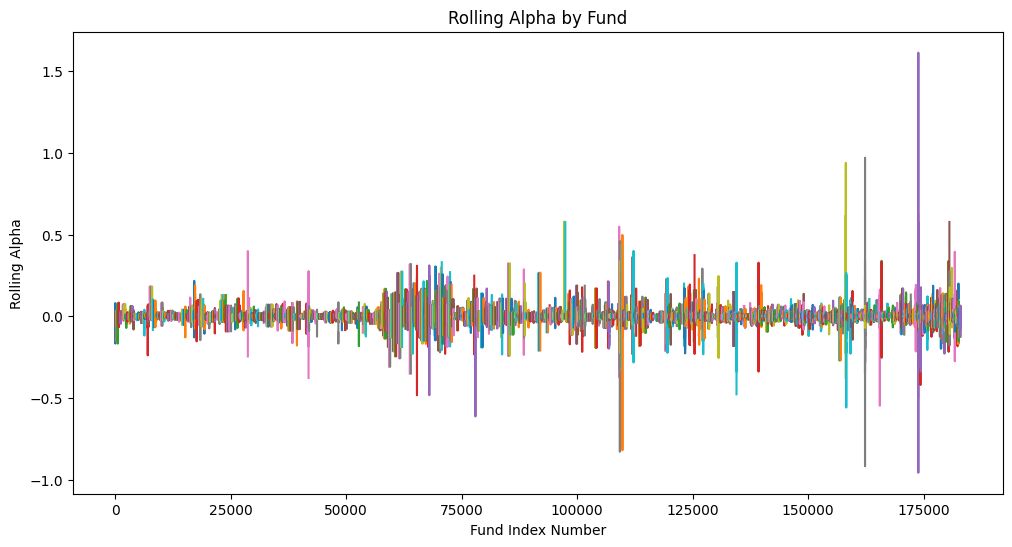

In [ ]:
plt.figure(figsize=(12, 6))

for fundno, group in df.groupby('crsp_fundno'):
    plt.plot(group.index, group['rolling_alpha_5f'], label=f'Fund {fundno}')

plt.xlabel('Fund Index Number')
plt.ylabel('Rolling Alpha')
plt.title('Rolling Alpha by Fund')
plt.show()

Plot 2: Plotting Median Alpha, and then Max and Min

In [39]:
df_plot = df.groupby('date')

Overall Training Cycle Code

In [13]:
# OLD HYPERPARAMS
# lstm_hyperparams_dict_healthcare = dict(
#     {'2019': dict({
#         'num_layers':3,
#         'units':[96,32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.2,0.2,0.1],
#         'activation':['tanh','tanh','linear'],
#         'lr':0.019962442034576384
#     }),
#      '2020': dict({
#         'num_layers':3,
#         'units':[64,32,32],
#         'optimizer':'Nadam',
#         'drop_out':[0.1,0.1,0.1],
#         'activation':['tanh','tanh','linear'],
#         'lr':0.021504061608420576
#     }),
#      '2021': dict({
#         'num_layers':3,
#         'units':[96,32,32],
#         'optimizer':'Nadam',
#         'drop_out':[0.1,0.1,0.1],
#         'activation':['tanh','tanh','linear'],
#         'lr':0.012302249555768368
#     }),
#      '2022': dict({
#         'num_layers':3,
#         'units':[96,32,32],
#         'optimizer':'Nadam',
#         'drop_out':[0.1,0.2,0.2],
#         'activation':['tanh','tanh','linear'],
#         'lr':0.010092957472413086
#     }),
#      '2023': dict({
#         'num_layers':2,
#         'units':[64,32],
#         'optimizer':'Adam',
#         'drop_out':[0.2,0.2],
#         'activation':['tanh','tanh'],
#         'lr':0.018388080425636798
#     }),
#      '2024': dict({
#         'num_layers':2,
#         'units':[32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.1,0.2],
#         'activation':['tanh','tanh'],
#         'lr':0.007947588699235507
#     })}
# )

rf_hyperparams_dict_healthcare = dict(
    {'2019': dict({
        'n_estimators':300,
        'min_samples_split':5,
        'min_samples_leaf':4,
        'max_features':'log2',
        'max_depth':20
    }),
     '2020': dict({
        'n_estimators':100,
        'min_samples_split':10,
        'min_samples_leaf':4,
        'max_features':'log2',
        'max_depth':None
    }),
     '2021': dict({
        'n_estimators':300,
        'min_samples_split':5,
        'min_samples_leaf':4,
        'max_features':'log2',
        'max_depth':20
    }),
     '2022': dict({
        'n_estimators':100,
        'min_samples_split':10,
        'min_samples_leaf':4,
        'max_features':'log2',
        'max_depth':None
    }),
     '2023': dict({
        'n_estimators':300,
        'min_samples_split':5,
        'min_samples_leaf':4,
        'max_features':'log2',
        'max_depth':20
    }),
     '2024': dict({
        'n_estimators':100,
        'min_samples_split':10,
        'min_samples_leaf':4,
        'max_features':'log2',
        'max_depth':None
    })}
)

Healthcare Mutual Funds

In [21]:
# Training Cycle
from tensorflow.keras.optimizers import Adam, Nadam, Adagrad

def overall_function(dataset, outcome, lstm_hyperparams_dict_healthcare, rf_hyperparams_dict_healthcare):
    dataset['date'] = pd.to_datetime(dataset['date']) # converting to date format
    dataset = dataset.sort_values(by='date')
    df_factor = dataset.drop(columns=['mkt_return','mth_return','rf']) # remove irrelevant variables

    # Creating Lagged and Stepped Datasets
    X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(df_factor, lag=1,target_var=outcome, id = 'crsp_fundno'),step=1,target_var=outcome, id = 'crsp_fundno_L1')
    # return(X_dataset)
    X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

    list_of_dates = pd.to_datetime(X_dataset['date_L1'])
    percentile_70 = list_of_dates.quantile(0.7) # 70-30 split
    train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
    df_end = list_of_dates.max()
    # return(y_dataset)
    results = []

    ## Implement cross-validation split
    tscv = TimeSeriesSplit(n_splits = 5)
    
    while train_end != df_end:
        
        test_date = generate_next_date(list_of_dates, train_end)
        if pd.isna(test_date):
            break 

        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
        
        # For Adding Results
        df_in_loop = y_test.copy()
        
        ### Model 1: Lasso Regression
        lasso_cv = LassoCV(cv = tscv, random_state = 18, max_iter = 100000)
        lasso_cv.fit(X_train, y_train)
        
        # Create the Lasso model with the optimal alpha value
        lasso_model = Lasso(alpha = lasso_cv.alpha_)
        lasso_model.fit(X_train, y_train)
        lassopred = lasso_model.predict(X_test)
        # Adding Linear Model
        df_in_loop[f'lasso'] = lassopred
        print('Lasso Done')
        
        ### Model 1: Ridge Regression ###
        ridge_cv = RidgeCV(cv = tscv)
        ridge_cv.fit(X_train, y_train)
    
        ridge_model = Ridge(alpha = ridge_cv.alpha_)
        ridge_model.fit(X_train, y_train)
        
        ridgepred = ridge_model.predict(X_test)
        # Adding Linear Model
        df_in_loop[f'ridge'] = ridgepred
        print('Ridge Done')
        
        ### Model 2: LSTM ###
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
        
        test_year = test_date.year
        print(f'test_year is {test_year} with hyperparameters of {lstm_hyperparams_dict_healthcare[str(test_year)]}')
        
        num_layers = len(lstm_hyperparams_dict_healthcare[str(test_year)]['units'])
        
        # Building LSTM Model
        lstm_model = Sequential()
        for layer_num in range(num_layers):
            is_last_layer = (layer_num == (num_layers - 1))  # Check if it's the last layer
            lstm_model.add(LSTM(
                units=lstm_hyperparams_dict_healthcare[str(test_year)]['units'][layer_num], 
                return_sequences=not is_last_layer,  # Only last layer has return_sequences=False
                input_shape=(X_train_lstm.shape[1], 1) if layer_num == 0 else None,  # Define input shape only for the first layer
                activation=lstm_hyperparams_dict_healthcare[str(test_year)]['activation'][layer_num]
            ))
            lstm_model.add(Dropout(lstm_hyperparams_dict_healthcare[str(test_year)]['drop_out'][layer_num]))
        # Output Layer
        lstm_model.add(Dense(units=1))
        
        # Compilation
        if lstm_hyperparams_dict_healthcare[str(test_year)]['optimizer'] == 'Adam':
            lstm_model.compile(
                optimizer=Adam(learning_rate=lstm_hyperparams_dict_healthcare[str(test_year)]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )
        elif lstm_hyperparams_dict_healthcare[str(test_year)]['optimizer'] == 'Nadam':
            lstm_model.compile(
                optimizer=Nadam(learning_rate=lstm_hyperparams_dict_healthcare[str(test_year)]['lr']),
                loss='mean_squared_error',
                metrics=[
                    tf.keras.metrics.RootMeanSquaredError()
                ]
            )

        # Early stopping callback
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

        # Train the model
        lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=10, batch_size=512,
            callbacks=[callback]
        )

        lstmpred = lstm_model.predict(X_test_lstm)
        df_in_loop[f'lstm'] = lstmpred
        print('LSTM Done')
        
        ### Model 3: Random Forest Regression ###
        print(f'test_year is {test_year} with hyperparameters of {rf_hyperparams_dict_healthcare[str(test_year)]}')
        rf_model = RandomForestRegressor(n_estimators=rf_hyperparams_dict_healthcare[str(test_year)]['n_estimators'], 
                                         min_samples_split=rf_hyperparams_dict_healthcare[str(test_year)]['min_samples_split'],
                                         min_samples_leaf=rf_hyperparams_dict_healthcare[str(test_year)]['min_samples_leaf'],
                                         max_features = rf_hyperparams_dict_healthcare[str(test_year)]['max_features'], 
                                         max_depth=rf_hyperparams_dict_healthcare[str(test_year)]['max_depth'],
                                         random_state=40, n_jobs=-1)

        rf_model.fit(X_train, y_train.values.ravel())
        rf_pred = rf_model.predict(X_test)
        # return(y_pred)
        df_in_loop[f'rf'] = rf_pred
        
        print('RF Done')
        
        ### Model 4: PCA ###
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        X_train_pure = X_train
        X_test_pure = X_test
        
        pca = PCA()
        pca.fit(X_train_pure)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
          #to explain more than 85% of the variance
        num_components = np.where(cumulative_variance_ratio >= 0.85)[0][0] + 1 
        pca_new = PCA(n_components=num_components)
        X_train_pca = pca_new.fit_transform(X_train_pure)
        X_train_pca = pd.DataFrame(X_train_pca)
        X_train_pca.columns = X_train_pca.columns.astype(str)

        X_test_pca = pca_new.transform(X_test_pure)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca.columns = X_test_pca.columns.astype(str)
        
        pure_factor_model = LinearRegression()
        pure_factor_model.fit(X_train_pca, y_train)
        y_pred = pure_factor_model.predict(X_test_pca)
        df_in_loop[f'pca'] = y_pred
        print('PCA Done')
        
        # return(y_pred)
        # Add results into loop
        results.append(df_in_loop)
        train_end = test_date
        num_remaining_dates = len(list(set(date for date in list_of_dates if date > test_date)))
        print(f'{num_remaining_dates} dates remaining')
    # return(results)
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df


In [22]:
# Run to train the models
y_new = overall_function(dataset=df, outcome = "rolling_alpha_5f", lstm_hyperparams_dict_healthcare=lstm_hyperparams_dict_healthcare, rf_hyperparams_dict_healthcare=rf_hyperparams_dict_healthcare)

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2019 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2], 'activation': ['tanh', 'sigmoid'], 'lr': 0.01995625160697196}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


251/251 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 0.0283 - root_mean_squared_error: 0.1513
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 4.5481e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 4.7007e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 4.7896e-04 - root_mean_squared_error: 0.0219
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 4.6564e-04 - root_mean_squared_error: 0.0216
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 4.4887e-04 - root_mean_squared_error: 0.0212
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 4.5293e-04 - root_mean_squared_error: 0.0213
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 4.5843e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 4.7191e-04 - root_mean_squared_error: 0.0217
Epoch 10/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/st

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


253/253 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.0121 - root_mean_squared_error: 0.1062
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 8.3633e-04 - root_mean_squared_error: 0.0289
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 6.2659e-04 - root_mean_squared_error: 0.0250
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 5.7151e-04 - root_mean_squared_error: 0.0239
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 4.9065e-04 - root_mean_squared_error: 0.0221
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 5.1454e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 4.9890e-04 - root_mean_squared_error: 0.0223
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 4.7711e-04 - root_mean_squared_error: 0.0218
Epoch 9/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 4.7207e-04 - root_mean_squared_error: 0.0217
Epoch 10/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/st

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


255/255 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - loss: 0.0399 - root_mean_squared_error: 0.1888
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 9.0151e-04 - root_mean_squared_error: 0.0300
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 7.6669e-04 - root_mean_squared_error: 0.0277
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 6.8117e-04 - root_mean_squared_error: 0.0261
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 6.1038e-04 - root_mean_squared_error: 0.0247
Epoch 9/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 63ms/step - loss: 5.6323e-04 - root_mean_squared_error: 0.0237
Epoch 10/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 5

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


257/257 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - loss: 0.0539 - root_mean_squared_error: 0.2170
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0044 - root_mean_squared_error: 0.0661
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0014 - root_mean_squared_error: 0.0367
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 8.6899e-04 - root_mean_squared_error: 0.0295
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 7.7589e-04 - root_mean_squared_error: 0.0278
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 7.1333e-04 - root_mean_squared_error: 0.0267
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 6.4071e-04 - root_mean_squared_error: 0.0253
Epoch 10/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 6.088

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - loss: 0.0419 - root_mean_squared_error: 0.1925
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 9.9495e-04 - root_mean_squared_error: 0.0315
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 8.6249e-04 - root_mean_squared_error: 0.0293
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 7.8113e-04 - root_mean_squared_error: 0.0279
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 6.9861e-04 - root_mean_squared_error: 0.0264
Epoch 9/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 6.7119e-04 - root_mean_squared_error: 0.0259
Epoch 10/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/ste

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - loss: 0.0094 - root_mean_squared_error: 0.0936
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 7.6951e-04 - root_mean_squared_error: 0.0277
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 5.9732e-04 - root_mean_squared_error: 0.0244
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 5.5260e-04 - root_mean_squared_error: 0.0235
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 6.0395e-04 - root_mean_squared_error: 0.0245
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 5.4771e-04 - root_mean_squared_error: 0.0234
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 5.1881e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 5.4534e-04 - root_mean_squared_error: 0.0233
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - loss: 5.1933e-04 - root_mean_squared_error: 0.0228
Epoch 10/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 0.0746 - root_mean_squared_error: 0.2528
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - loss: 0.0075 - root_mean_squared_error: 0.0862
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 9.6459e-04 - root_mean_squared_error: 0.0310
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 7.9348e-04 - root_mean_squared_error: 0.0282
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 7.9065e-04 - root_mean_squared_error: 0.0279
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - loss: 0.0501 - root_mean_squared_error: 0.2109
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 0.0058 - root_mean_squared_error: 0.0758
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 9.3177e-04 - root_mean_squared_error: 0.0305
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 8.1139e-04 - root_mean_squared_error: 0.0285
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 7.2698e-04 - root_mean_squared_error: 0.0270
Epoch 9/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 6.4960e-04 - root_mean_squared_error: 0.0255
Epoch 10/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - 

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 26s 71ms/step - loss: 0.0428 - root_mean_squared_error: 0.1969
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 8.8593e-04 - root_mean_squared_error: 0.0298
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - loss: 7.7432e-04 - root_mean_squared_error: 0.0278
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 7.1185e-04 - root_mean_squared_error: 0.0267
Epoch 9/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 6.1490e-04 - root_mean_squared_error: 0.0248
Epoch 10/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - 

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.0253 - root_mean_squared_error: 0.1546
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - loss: 8.5792e-04 - root_mean_squared_error: 0.0293
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 6.9711e-04 - root_mean_squared_error: 0.0264
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 6.3745e-04 - root_mean_squared_error: 0.0252
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 6.1771e-04 - root_mean_squared_error: 0.0248
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 6.0406e-04 - root_mean_squared_error: 0.0246
Epoch 9/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 5.4901e-04 - root_mean_squared_error: 0.0234
Epoch 10/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - loss: 0.0212 - root_mean_squared_error: 0.1418
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 7.7444e-04 - root_mean_squared_error: 0.0278
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 6.5415e-04 - root_mean_squared_error: 0.0256
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 6.2493e-04 - root_mean_squared_error: 0.0250
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 6.5316e-04 - root_mean_squared_error: 0.0255
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - loss: 6.2840e-04 - root_mean_squared_error: 0.0250
Epoch 9/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - loss: 5.8296e-04 - root_mean_squared_error: 0.0241
Epoch 10/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - loss: 0.0225 - root_mean_squared_error: 0.1465
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 8.0463e-04 - root_mean_squared_error: 0.0284
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 6.6148e-04 - root_mean_squared_error: 0.0257
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - loss: 6.9593e-04 - root_mean_squared_error: 0.0263
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 5.9429e-04 - root_mean_squared_error: 0.0244
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 5.7232e-04 - root_mean_squared_error: 0.0239
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 5.7770e-04 - root_mean_squared_error: 0.0240
Epoch 10/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2020 with hyperparameters of {'num_layers': 3, 'units': [32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.2, 0.1], 'activation': ['linear', 'sigmoid', 'sigmoid'], 'lr': 0.0011839804874350056}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - loss: 0.0127 - root_mean_squared_error: 0.1096
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 6.9375e-04 - root_mean_squared_error: 0.0263
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 6.5697e-04 - root_mean_squared_error: 0.0256
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 5.5437e-04 - root_mean_squared_error: 0.0235
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - loss: 6.0732e-04 - root_mean_squared_error: 0.0245
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 5.6871e-04 - root_mean_squared_error: 0.0238
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 5.1389e-04 - root_mean_squared_error: 0.0226
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - loss: 6.0649e-04 - root_mean_squared_error: 0.0246
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - loss: 0.0310 - root_mean_squared_error: 0.1461
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - loss: 5.1606e-04 - root_mean_squared_error: 0.0227
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 35s 127ms/step - loss: 5.1240e-04 - root_mean_squared_error: 0.0226
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 36s 128ms/step - loss: 0.0050 - root_mean_squared_error: 0.0655
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - loss: 5.1027e-04 - root_mean_squared_error: 0.0226
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - loss: 4.6381e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - loss: 4.7031e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - loss: 4.7983e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - loss: 4.8324e-04 - root_mean_squared_error: 0.0220
Epoch 10/10
278/278 ━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 38s 116ms/step - loss: 0.0066 - root_mean_squared_error: 0.0688
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - loss: 4.9656e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 5.0053e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 4.8442e-04 - root_mean_squared_error: 0.0220
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 5.1494e-04 - root_mean_squared_error: 0.0227
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 4.9972e-04 - root_mean_squared_error: 0.0223
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 4.9686e-04 - root_mean_squared_error: 0.0223
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 4.2449e-04 - root_mean_squared_error: 0.0206
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 4.8455e-04 - root_mean_squared_error: 0.0220
Epoch 10/10
280/280 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - loss: 0.0028 - root_mean_squared_error: 0.0467
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 5.0784e-04 - root_mean_squared_error: 0.0225
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - loss: 4.6885e-04 - root_mean_squared_error: 0.0216
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 4.5955e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 4.7815e-04 - root_mean_squared_error: 0.0219
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 4.9496e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 4.6175e-04 - root_mean_squared_error: 0.0215
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - loss: 4.4922e-04 - root_mean_squared_error: 0.0212
Epoch 9/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 4.2453e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 32

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - loss: 0.0056 - root_mean_squared_error: 0.0651
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - loss: 5.2619e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 5.1639e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 4.4444e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 4.2487e-04 - root_mean_squared_error: 0.0206
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 5.0640e-04 - root_mean_squared_error: 0.0225
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - loss: 4.3241e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 4.0848e-04 - root_mean_squared_error: 0.0202
Epoch 9/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 32s 114ms/step - loss: 5.2146e-04 - root_mean_squared_error: 0.0228
Epoch 10/10
284/284 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - loss: 0.0089 - root_mean_squared_error: 0.0797
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 4.9910e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 5.0193e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 32s 113ms/step - loss: 4.9190e-04 - root_mean_squared_error: 0.0222
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 6.0980e-04 - root_mean_squared_error: 0.0243
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 5.1164e-04 - root_mean_squared_error: 0.0226
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 5.2304e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 36s 125ms/step - loss: 4.4581e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 4.5320e-04 - root_mean_squared_error: 0.0213
Epoch 10/10
286/286 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - loss: 0.0079 - root_mean_squared_error: 0.0755
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 4.9730e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 4.8920e-04 - root_mean_squared_error: 0.0221
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 34s 117ms/step - loss: 4.8849e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - loss: 4.5545e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 4.7498e-04 - root_mean_squared_error: 0.0218
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 4.7061e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 4.4242e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 4.2423e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
288/288 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 115ms/step - loss: 0.0034 - root_mean_squared_error: 0.0506
Epoch 2/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 4.5627e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 120ms/step - loss: 4.7713e-04 - root_mean_squared_error: 0.0218
Epoch 4/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 4.9014e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - loss: 4.2772e-04 - root_mean_squared_error: 0.0207
Epoch 6/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 33s 115ms/step - loss: 4.7246e-04 - root_mean_squared_error: 0.0217
Epoch 7/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - loss: 4.6456e-04 - root_mean_squared_error: 0.0215
Epoch 8/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - loss: 3.9105e-04 - root_mean_squared_error: 0.0198
Epoch 9/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 33s 114ms/step - loss: 4.7404e-04 - root_mean_squared_error: 0.0218
Epoch 10/10
290/290 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 40s 120ms/step - loss: 0.0098 - root_mean_squared_error: 0.0846
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 5.2293e-04 - root_mean_squared_error: 0.0228
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - loss: 5.0473e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - loss: 4.5301e-04 - root_mean_squared_error: 0.0213
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 34s 118ms/step - loss: 4.6890e-04 - root_mean_squared_error: 0.0216
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - loss: 4.5155e-04 - root_mean_squared_error: 0.0212
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 5.4212e-04 - root_mean_squared_error: 0.0231
Epoch 8/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 5.1320e-04 - root_mean_squared_error: 0.0226
Epoch 9/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 36s 123ms/step - loss: 4.6850e-04 - root_mean_squared_error: 0.0216
Epoch 10/10
292/292 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.0037 - root_mean_squared_error: 0.0527
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - loss: 4.7814e-04 - root_mean_squared_error: 0.0219
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 4.9975e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - loss: 4.6571e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 4.3786e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 5.1432e-04 - root_mean_squared_error: 0.0226
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 4.6987e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - loss: 4.3879e-04 - root_mean_squared_error: 0.0209
Epoch 9/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 4.4385e-04 - root_mean_squared_error: 0.0210
Epoch 10/10
294/294 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - loss: 0.0074 - root_mean_squared_error: 0.0729
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 4.7323e-04 - root_mean_squared_error: 0.0217
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 37s 126ms/step - loss: 4.8016e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 4.2845e-04 - root_mean_squared_error: 0.0207
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 4.4452e-04 - root_mean_squared_error: 0.0211
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 116ms/step - loss: 4.9297e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - loss: 4.6474e-04 - root_mean_squared_error: 0.0215
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 4.4293e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 4.6371e-04 - root_mean_squared_error: 0.0215
Epoch 10/10
296/296 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - loss: 0.0037 - root_mean_squared_error: 0.0535
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 4.6543e-04 - root_mean_squared_error: 0.0216
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - loss: 4.3042e-04 - root_mean_squared_error: 0.0207
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 4.2522e-04 - root_mean_squared_error: 0.0206
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 36s 122ms/step - loss: 4.7846e-04 - root_mean_squared_error: 0.0218
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - loss: 4.3518e-04 - root_mean_squared_error: 0.0208
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 34s 115ms/step - loss: 4.1012e-04 - root_mean_squared_error: 0.0202
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - loss: 4.4669e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - loss: 4.5260e-04 - root_mean_squared_error: 0.0213
Epoch 10/10
298/298 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2021 with hyperparameters of {'num_layers': 2, 'units': [128, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'linear'], 'lr': 0.018389663547277172}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - loss: 0.0052 - root_mean_squared_error: 0.0618
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - loss: 4.8480e-04 - root_mean_squared_error: 0.0220
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - loss: 4.4584e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 115ms/step - loss: 4.2844e-04 - root_mean_squared_error: 0.0207
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - loss: 4.3027e-04 - root_mean_squared_error: 0.0207
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - loss: 4.8989e-04 - root_mean_squared_error: 0.0220
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 35s 116ms/step - loss: 4.3265e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - loss: 4.5296e-04 - root_mean_squared_error: 0.0213
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - loss: 4.0453e-04 - root_mean_squared_error: 0.0201
Epoch 10/10
300/300 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - loss: 0.0012 - root_mean_squared_error: 0.0322
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - loss: 4.8572e-04 - root_mean_squared_error: 0.0220
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - loss: 4.6011e-04 - root_mean_squared_error: 0.0214
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - loss: 5.2301e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - loss: 4.8901e-04 - root_mean_squared_error: 0.0221
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - loss: 5.5311e-04 - root_mean_squared_error: 0.0235
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
32 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - loss: 0.0012 - root_mean_squared_error: 0.0321
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - loss: 4.5727e-04 - root_mean_squared_error: 0.0214
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 4.7185e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - loss: 5.1754e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 5.1694e-04 - root_mean_squared_error: 0.0227
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
31 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - loss: 0.0019 - root_mean_squared_error: 0.0396
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 4.7512e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 111ms/step - loss: 4.5412e-04 - root_mean_squared_error: 0.0213
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 5.2538e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - loss: 4.9115e-04 - root_mean_squared_error: 0.0222
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
30 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 0.0020 - root_mean_squared_error: 0.0398
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 4.9155e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 5.0700e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - loss: 5.1363e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 5.2956e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - loss: 5.2456e-04 - root_mean_squared_error: 0.0229
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - loss: 5.1002e-04 - root_mean_squared_error: 0.0226
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step - loss: 4.9521e-04 - root_mean_squared_error: 0.0222
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - loss: 4.9357e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
309/309 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 44s 109ms/step - loss: 0.0015 - root_mean_squared_error: 0.0355
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 5.1347e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - loss: 4.4632e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 5.4510e-04 - root_mean_squared_error: 0.0232
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - loss: 4.9982e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 33s 107ms/step - loss: 5.2227e-04 - root_mean_squared_error: 0.0228
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
28 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 115ms/step - loss: 0.0012 - root_mean_squared_error: 0.0327
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step - loss: 5.2901e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 4.8609e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - loss: 4.8303e-04 - root_mean_squared_error: 0.0220
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 5.3915e-04 - root_mean_squared_error: 0.0232
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
27 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 43s 105ms/step - loss: 0.0012 - root_mean_squared_error: 0.0323
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - loss: 5.1089e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - loss: 4.9206e-04 - root_mean_squared_error: 0.0222
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 5.3057e-04 - root_mean_squared_error: 0.0230
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 5.3079e-04 - root_mean_squared_error: 0.0230
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
26 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 45s 108ms/step - loss: 0.0011 - root_mean_squared_error: 0.0313
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - loss: 5.3725e-04 - root_mean_squared_error: 0.0231
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - loss: 5.0461e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - loss: 5.1244e-04 - root_mean_squared_error: 0.0226
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - loss: 5.3046e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 4.7884e-04 - root_mean_squared_error: 0.0219
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - loss: 5.0461e-04 - root_mean_squared_error: 0.0224
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 5.2452e-04 - root_mean_squared_error: 0.0229
Epoch 9/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - loss: 5.4371e-04 - root_mean_squared_error: 0.0232
Epoch 10/10
317/317 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 44s 106ms/step - loss: 0.0010 - root_mean_squared_error: 0.0306
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - loss: 5.7501e-04 - root_mean_squared_error: 0.0238
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - loss: 4.7782e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - loss: 5.8207e-04 - root_mean_squared_error: 0.0241
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - loss: 5.1817e-04 - root_mean_squared_error: 0.0228
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - loss: 5.0983e-04 - root_mean_squared_error: 0.0226
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
24 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 46s 107ms/step - loss: 0.0017 - root_mean_squared_error: 0.0375
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 35s 108ms/step - loss: 6.3271e-04 - root_mean_squared_error: 0.0250
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 4.9184e-04 - root_mean_squared_error: 0.0222
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 5.1394e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 35s 109ms/step - loss: 4.9148e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - loss: 5.3299e-04 - root_mean_squared_error: 0.0231
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 40s 124ms/step - loss: 5.0780e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - loss: 5.1250e-04 - root_mean_squared_error: 0.0226
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, '

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 47s 112ms/step - loss: 0.0021 - root_mean_squared_error: 0.0410
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - loss: 5.0235e-04 - root_mean_squared_error: 0.0224
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 35s 107ms/step - loss: 4.8395e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 5.1698e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 4.7579e-04 - root_mean_squared_error: 0.0218
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
22 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2022 with hyperparameters of {'num_layers': 4, 'units': [64, 32, 32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.1, 0.2, 0.2], 'activation': ['linear', 'tanh', 'tanh', 'linear'], 'lr': 0.011965744369339311}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - loss: 0.0011 - root_mean_squared_error: 0.0311
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - loss: 4.7419e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 4.9340e-04 - root_mean_squared_error: 0.0222
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 5.1113e-04 - root_mean_squared_error: 0.0226
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 5.3864e-04 - root_mean_squared_error: 0.0232
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step
LSTM Done
test_year is 2022 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
21 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - loss: 5.1956e-04 - root_mean_squared_error: 0.0228
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 5.0722e-04 - root_mean_squared_error: 0.0225
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.5924e-04 - root_mean_squared_error: 0.0214
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 4.7495e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 4.5856e-04 - root_mean_squared_error: 0.0214
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 4.6697e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.4991e-04 - root_mean_squared_error: 0.0212
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 4.4378e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.7910e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 5.7147e-04 - root_mean_squared_error: 0.0238
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 5.0423e-04 - root_mean_squared_error: 0.0224
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.8320e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.5653e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.6348e-04 - root_mean_squared_error: 0.0215
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.5918e-04 - root_mean_squared_error: 0.0214
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.9636e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.6282e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.3848e-04 - root_mean_squared_error: 0.0209
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


331/331 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 6.0637e-04 - root_mean_squared_error: 0.0245
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 4.7390e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.8060e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - loss: 5.2012e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 4.9965e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.8089e-04 - root_mean_squared_error: 0.0219
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.5337e-04 - root_mean_squared_error: 0.0213
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - loss: 4.5306e-04 - root_mean_squared_error: 0.0213
Epoch 9/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.5652e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 15s 45m

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 6.0739e-04 - root_mean_squared_error: 0.0245
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.8681e-04 - root_mean_squared_error: 0.0221
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 5.0680e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 4.8275e-04 - root_mean_squared_error: 0.0219
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.5319e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.6429e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.6663e-04 - root_mean_squared_error: 0.0216
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.5368e-04 - root_mean_squared_error: 0.0213
Epoch 9/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.6042e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
333/333 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 6.2332e-04 - root_mean_squared_error: 0.0249
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.9440e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.6053e-04 - root_mean_squared_error: 0.0214
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.8854e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 5.0135e-04 - root_mean_squared_error: 0.0224
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.5232e-04 - root_mean_squared_error: 0.0213
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.7235e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.6519e-04 - root_mean_squared_error: 0.0216
Epoch 9/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.9477e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
335/335 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 5.8164e-04 - root_mean_squared_error: 0.0241
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 5.0765e-04 - root_mean_squared_error: 0.0225
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.7031e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.4577e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.4394e-04 - root_mean_squared_error: 0.0211
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.2892e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.6513e-04 - root_mean_squared_error: 0.0216
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.5686e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.3776e-04 - root_mean_squared_error: 0.0209
Epoch 10/10
337/337 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 6.2406e-04 - root_mean_squared_error: 0.0249
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.7580e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.7334e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - loss: 4.9633e-04 - root_mean_squared_error: 0.0223
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.3677e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.6599e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.7269e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.6591e-04 - root_mean_squared_error: 0.0216
Epoch 9/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.7878e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
339/339 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 6.0138e-04 - root_mean_squared_error: 0.0245
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.7483e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.7915e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.3623e-04 - root_mean_squared_error: 0.0209
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.5355e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.8247e-04 - root_mean_squared_error: 0.0219
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.8947e-04 - root_mean_squared_error: 0.0221
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.7286e-04 - root_mean_squared_error: 0.0217
Epoch 9/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - loss: 4.5596e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
341/341 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 6.0977e-04 - root_mean_squared_error: 0.0246
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 5.0548e-04 - root_mean_squared_error: 0.0225
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.4026e-04 - root_mean_squared_error: 0.0210
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - loss: 4.8330e-04 - root_mean_squared_error: 0.0220
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.8352e-04 - root_mean_squared_error: 0.0220
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.6730e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 5.2022e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.5872e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.4771e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
343/343 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 5.6350e-04 - root_mean_squared_error: 0.0237
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.6367e-04 - root_mean_squared_error: 0.0215
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.6428e-04 - root_mean_squared_error: 0.0215
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.9158e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.7808e-04 - root_mean_squared_error: 0.0219
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.9679e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.6861e-04 - root_mean_squared_error: 0.0216
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.6265e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - loss: 4.3507e-04 - root_mean_squared_error: 0.0208
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - loss: 5.2859e-04 - root_mean_squared_error: 0.0230
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.5331e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.5518e-04 - root_mean_squared_error: 0.0213
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.3864e-04 - root_mean_squared_error: 0.0209
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 4.3183e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - loss: 4.5132e-04 - root_mean_squared_error: 0.0212
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.7414e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.1786e-04 - root_mean_squared_error: 0.0204
Epoch 9/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 4.6126e-04 - root_mean_squared_error: 0.0215
Epoch 10/10
346/346 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2023 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.2, 0.1], 'activation': ['tanh', 'tanh'], 'lr': 0.0005130193097484537}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 5.2590e-04 - root_mean_squared_error: 0.0229
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - loss: 4.9559e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.6932e-04 - root_mean_squared_error: 0.0216
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.3132e-04 - root_mean_squared_error: 0.0208
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.3129e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.3736e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.4217e-04 - root_mean_squared_error: 0.0210
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.3467e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.4298e-04 - root_mean_squared_error: 0.0210
Epoch 10/10
348/348 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 5.8480e-04 - root_mean_squared_error: 0.0240
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.9853e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 4.4733e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 5.1098e-04 - root_mean_squared_error: 0.0225
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.2250e-04 - root_mean_squared_error: 0.0205
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.1816e-04 - root_mean_squared_error: 0.0204
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.4133e-04 - root_mean_squared_error: 0.0210
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.2830e-04 - root_mean_squared_error: 0.0207
Epoch 9/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.0557e-04 - root_mean_squared_error: 0.0201
Epoch 10/10
349/349 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 5.6690e-04 - root_mean_squared_error: 0.0237
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.7171e-04 - root_mean_squared_error: 0.0217
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.7933e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.3895e-04 - root_mean_squared_error: 0.0209
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.8988e-04 - root_mean_squared_error: 0.0221
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 4.2974e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 4.1400e-04 - root_mean_squared_error: 0.0203
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.5960e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 3.9103e-04 - root_mean_squared_error: 0.0198
Epoch 10/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 41m

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 6.8034e-04 - root_mean_squared_error: 0.0258
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.6735e-04 - root_mean_squared_error: 0.0216
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.6230e-04 - root_mean_squared_error: 0.0215
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.8786e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 4.2644e-04 - root_mean_squared_error: 0.0206
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.3997e-04 - root_mean_squared_error: 0.0210
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.2829e-04 - root_mean_squared_error: 0.0207
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.3152e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.2338e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
351/351 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}
Epoch 1/10


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 6.2079e-04 - root_mean_squared_error: 0.0248
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.7405e-04 - root_mean_squared_error: 0.0217
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.4339e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.9634e-04 - root_mean_squared_error: 0.0222
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.5350e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.0099e-04 - root_mean_squared_error: 0.0200
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.1646e-04 - root_mean_squared_error: 0.0204
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 4.1657e-04 - root_mean_squared_error: 0.0204
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.0334e-04 - root_mean_squared_error: 0.0201
Epoch 10/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 45m

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 7.3933e-04 - root_mean_squared_error: 0.0265
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.7918e-04 - root_mean_squared_error: 0.0219
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 5.1162e-04 - root_mean_squared_error: 0.0226
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.8397e-04 - root_mean_squared_error: 0.0220
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.5373e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.3681e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.7767e-04 - root_mean_squared_error: 0.0218
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
LSTM Done
test_year is 2024 with hyperparameters of {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
RF Done
PCA Done
4 dates remaining


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 6.2594e-04 - root_mean_squared_error: 0.0248
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.9199e-04 - root_mean_squared_error: 0.0221
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - loss: 4.6874e-04 - root_mean_squared_error: 0.0216
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.7138e-04 - root_mean_squared_error: 0.0217
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.4038e-04 - root_mean_squared_error: 0.0210
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.5073e-04 - root_mean_squared_error: 0.0212
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.4649e-04 - root_mean_squared_error: 0.0211
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.3034e-04 - root_mean_squared_error: 0.0207
Epoch 9/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.4509e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
354/354 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 6.2217e-04 - root_mean_squared_error: 0.0248
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.6458e-04 - root_mean_squared_error: 0.0215
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.8271e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.4719e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.7674e-04 - root_mean_squared_error: 0.0218
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.2995e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.6774e-04 - root_mean_squared_error: 0.0216
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.3797e-04 - root_mean_squared_error: 0.0209
Epoch 9/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - loss: 4.2745e-04 - root_mean_squared_error: 0.0207
Epoch 10/10
354/354 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 6.4067e-04 - root_mean_squared_error: 0.0251
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.8959e-04 - root_mean_squared_error: 0.0220
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.7021e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.7766e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.6737e-04 - root_mean_squared_error: 0.0216
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.1705e-04 - root_mean_squared_error: 0.0204
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.5622e-04 - root_mean_squared_error: 0.0214
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.8059e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.4505e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
355/355 ━━━━━━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso Done
Ridge Done
test_year is 2024 with hyperparameters of {'num_layers': 2, 'units': [32, 32], 'optimizer': 'Adam', 'drop_out': [0.1, 0.2], 'activation': ['linear', 'tanh'], 'lr': 0.0035163892485339547}


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 29s 43ms/step - loss: 6.8770e-04 - root_mean_squared_error: 0.0258
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 4.7484e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.7202e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.3508e-04 - root_mean_squared_error: 0.0208
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.4081e-04 - root_mean_squared_error: 0.0210
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - loss: 4.3109e-04 - root_mean_squared_error: 0.0208
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 4.5461e-04 - root_mean_squared_error: 0.0213
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.6168e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - loss: 4.1724e-04 - root_mean_squared_error: 0.0204
Epoch 10/10
355/355 ━━━━━━━━━━━━━━━━━

In [48]:
# Run to train the models
y_new = overall_function(dataset=df, outcome = "rolling_alpha_5f")

Ridge Done


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 48s 140ms/step - loss: 6.2459e-04 - root_mean_squared_error: 0.0245
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - loss: 4.3185e-04 - root_mean_squared_error: 0.0208
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - loss: 4.4359e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - loss: 4.3802e-04 - root_mean_squared_error: 0.0209
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - loss: 3.9029e-04 - root_mean_squared_error: 0.0197
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - loss: 3.9700e-04 - root_mean_squared_error: 0.0199
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - loss: 4.0600e-04 - root_mean_squared_error: 0.0201
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - loss: 3.9520e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - loss: 3.8697e-04 - root_mean_squared_error: 0.0197
Epoch 10/10
251/251 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - loss: 6.9183e-04 - root_mean_squared_error: 0.0255
Epoch 2/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - loss: 4.5251e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 38s 151ms/step - loss: 4.2671e-04 - root_mean_squared_error: 0.0207
Epoch 4/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - loss: 4.5154e-04 - root_mean_squared_error: 0.0212
Epoch 5/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - loss: 4.1829e-04 - root_mean_squared_error: 0.0204
Epoch 6/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 43s 169ms/step - loss: 4.0652e-04 - root_mean_squared_error: 0.0202
Epoch 7/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - loss: 4.2139e-04 - root_mean_squared_error: 0.0205
Epoch 8/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - loss: 3.9514e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
253/253 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - loss: 3.9343e-04 - root_mean_squared_error: 0.0198
Epoch 10/10
253/253 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 51s 162ms/step - loss: 8.7504e-04 - root_mean_squared_error: 0.0283
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - loss: 4.6919e-04 - root_mean_squared_error: 0.0217
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - loss: 4.6305e-04 - root_mean_squared_error: 0.0215
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - loss: 4.5260e-04 - root_mean_squared_error: 0.0213
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - loss: 4.3526e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 38s 150ms/step - loss: 4.3064e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - loss: 3.9937e-04 - root_mean_squared_error: 0.0200
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - loss: 4.1477e-04 - root_mean_squared_error: 0.0204
Epoch 9/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - loss: 4.2142e-04 - root_mean_squared_error: 0.0205
Epoch 10/10
255/255 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 53s 165ms/step - loss: 9.0494e-04 - root_mean_squared_error: 0.0290
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - loss: 4.9298e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - loss: 4.8142e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 161ms/step - loss: 4.5172e-04 - root_mean_squared_error: 0.0212
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - loss: 4.6152e-04 - root_mean_squared_error: 0.0215
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - loss: 4.5539e-04 - root_mean_squared_error: 0.0213
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - loss: 4.0513e-04 - root_mean_squared_error: 0.0201
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - loss: 4.0452e-04 - root_mean_squared_error: 0.0201
Epoch 9/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 43s 168ms/step - loss: 3.8923e-04 - root_mean_squared_error: 0.0197
Epoch 10/10
257/257 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - loss: 8.1995e-04 - root_mean_squared_error: 0.0279
Epoch 2/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 5.8000e-04 - root_mean_squared_error: 0.0239
Epoch 3/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.8568e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - loss: 4.9684e-04 - root_mean_squared_error: 0.0222
Epoch 5/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.7602e-04 - root_mean_squared_error: 0.0218
Epoch 6/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - loss: 4.4201e-04 - root_mean_squared_error: 0.0210
Epoch 7/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - loss: 5.5328e-04 - root_mean_squared_error: 0.0235
Epoch 8/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - loss: 5.0493e-04 - root_mean_squared_error: 0.0224
Epoch 9/10
259/259 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - loss: 5.4044e-04 - root_mean_squared_error: 0.0232
Epoch 10/10
259/259 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 43s 135ms/step - loss: 8.1533e-04 - root_mean_squared_error: 0.0276
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 5.4006e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - loss: 5.2541e-04 - root_mean_squared_error: 0.0229
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.7184e-04 - root_mean_squared_error: 0.0217
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - loss: 4.8553e-04 - root_mean_squared_error: 0.0220
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - loss: 4.5970e-04 - root_mean_squared_error: 0.0214
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - loss: 4.2198e-04 - root_mean_squared_error: 0.0205
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - loss: 4.5601e-04 - root_mean_squared_error: 0.0213
Epoch 9/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.7440e-04 - root_mean_squared_error: 0.0218
Epoch 10/10
261/261 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 43s 135ms/step - loss: 7.2228e-04 - root_mean_squared_error: 0.0263
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - loss: 5.2862e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 5.3111e-04 - root_mean_squared_error: 0.0230
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.6821e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.9872e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.6558e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - loss: 4.7787e-04 - root_mean_squared_error: 0.0218
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 4.7041e-04 - root_mean_squared_error: 0.0217
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - loss: 4.4019e-04 - root_mean_squared_error: 0.0210
Epoch 10/10
263/263 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 9.7818e-04 - root_mean_squared_error: 0.0299
Epoch 2/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 5.4782e-04 - root_mean_squared_error: 0.0234
Epoch 3/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 5.0027e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 5.4264e-04 - root_mean_squared_error: 0.0233
Epoch 5/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - loss: 4.5587e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - loss: 4.6790e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 5.0115e-04 - root_mean_squared_error: 0.0224
Epoch 8/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.5019e-04 - root_mean_squared_error: 0.0212
Epoch 9/10
265/265 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.4492e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
265/265 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 6.9361e-04 - root_mean_squared_error: 0.0260
Epoch 2/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 5.1004e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 4.8337e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.5127e-04 - root_mean_squared_error: 0.0212
Epoch 5/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.9304e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.9893e-04 - root_mean_squared_error: 0.0223
Epoch 7/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.8722e-04 - root_mean_squared_error: 0.0220
Epoch 8/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.3457e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
267/267 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.5433e-04 - root_mean_squared_error: 0.0213
Epoch 10/10
267/267 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - loss: 8.1883e-04 - root_mean_squared_error: 0.0279
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 5.4127e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 4.6781e-04 - root_mean_squared_error: 0.0216
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - loss: 4.7385e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - loss: 4.8164e-04 - root_mean_squared_error: 0.0219
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.7015e-04 - root_mean_squared_error: 0.0217
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.5825e-04 - root_mean_squared_error: 0.0214
Epoch 8/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 4.2827e-04 - root_mean_squared_error: 0.0207
Epoch 9/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 4.5077e-04 - root_mean_squared_error: 0.0212
Epoch 10/10
270/270 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 9.3796e-04 - root_mean_squared_error: 0.0292
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - loss: 5.0034e-04 - root_mean_squared_error: 0.0224
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.8156e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.6856e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.8034e-04 - root_mean_squared_error: 0.0219
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - loss: 5.1525e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 4.2907e-04 - root_mean_squared_error: 0.0207
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - loss: 5.3583e-04 - root_mean_squared_error: 0.0231
Epoch 9/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - loss: 4.6597e-04 - root_mean_squared_error: 0.0216
Epoch 10/10
272/272 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - loss: 9.8191e-04 - root_mean_squared_error: 0.0302
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 5.3801e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 5.5244e-04 - root_mean_squared_error: 0.0235
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.7813e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.9500e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.6669e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.6989e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.5277e-04 - root_mean_squared_error: 0.0213
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.4912e-04 - root_mean_squared_error: 0.0212
Epoch 10/10
274/274 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - loss: 7.3266e-04 - root_mean_squared_error: 0.0264
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.9962e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - loss: 5.3177e-04 - root_mean_squared_error: 0.0230
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.5295e-04 - root_mean_squared_error: 0.0213
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.5882e-04 - root_mean_squared_error: 0.0214
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - loss: 4.8332e-04 - root_mean_squared_error: 0.0220
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - loss: 4.7808e-04 - root_mean_squared_error: 0.0219
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - loss: 4.4525e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - loss: 4.5180e-04 - root_mean_squared_error: 0.0212
Epoch 10/10
276/276 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 7.7443e-04 - root_mean_squared_error: 0.0273
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 5.2497e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 5.2244e-04 - root_mean_squared_error: 0.0228
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.7205e-04 - root_mean_squared_error: 0.0217
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 5.1644e-04 - root_mean_squared_error: 0.0227
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.3903e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.2783e-04 - root_mean_squared_error: 0.0207
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 5.2471e-04 - root_mean_squared_error: 0.0229
Epoch 9/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - loss: 4.2661e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
278/278 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 9.6036e-04 - root_mean_squared_error: 0.0296
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.7513e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 5.2019e-04 - root_mean_squared_error: 0.0228
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.6792e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.3017e-04 - root_mean_squared_error: 0.0207
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.8632e-04 - root_mean_squared_error: 0.0220
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.3801e-04 - root_mean_squared_error: 0.0209
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 4.3307e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 3.9032e-04 - root_mean_squared_error: 0.0197
Epoch 10/10
280/280 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - loss: 9.8258e-04 - root_mean_squared_error: 0.0299
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 5.2524e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.8575e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 4.5869e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 4.6294e-04 - root_mean_squared_error: 0.0215
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - loss: 4.5711e-04 - root_mean_squared_error: 0.0214
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 4.9955e-04 - root_mean_squared_error: 0.0223
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - loss: 3.9761e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.6426e-04 - root_mean_squared_error: 0.0215
Epoch 10/10
282/282 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - loss: 8.2441e-04 - root_mean_squared_error: 0.0279
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 5.2090e-04 - root_mean_squared_error: 0.0228
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 5.1566e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - loss: 5.1762e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 4.8485e-04 - root_mean_squared_error: 0.0220
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.1897e-04 - root_mean_squared_error: 0.0205
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.8825e-04 - root_mean_squared_error: 0.0221
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.5187e-04 - root_mean_squared_error: 0.0212
Epoch 9/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.1722e-04 - root_mean_squared_error: 0.0204
Epoch 10/10
284/284 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 7.5643e-04 - root_mean_squared_error: 0.0269
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.9893e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 5.3127e-04 - root_mean_squared_error: 0.0230
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 4.9665e-04 - root_mean_squared_error: 0.0223
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 4.4813e-04 - root_mean_squared_error: 0.0211
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.6284e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.8235e-04 - root_mean_squared_error: 0.0219
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.5913e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - loss: 4.3648e-04 - root_mean_squared_error: 0.0209
Epoch 10/10
286/286 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - loss: 8.9409e-04 - root_mean_squared_error: 0.0287
Epoch 2/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.9747e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - loss: 4.8350e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.4610e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - loss: 4.8680e-04 - root_mean_squared_error: 0.0220
Epoch 6/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - loss: 4.3623e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - loss: 4.2643e-04 - root_mean_squared_error: 0.0206
Epoch 8/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.3663e-04 - root_mean_squared_error: 0.0209
Epoch 9/10
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - loss: 4.6985e-04 - root_mean_squared_error: 0.0217
Epoch 10/10
288/288 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - loss: 8.2971e-04 - root_mean_squared_error: 0.0281
Epoch 2/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 5.2935e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.7216e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - loss: 4.7096e-04 - root_mean_squared_error: 0.0217
Epoch 5/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.7044e-04 - root_mean_squared_error: 0.0217
Epoch 6/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.6196e-04 - root_mean_squared_error: 0.0214
Epoch 7/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.6981e-04 - root_mean_squared_error: 0.0216
Epoch 8/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - loss: 4.3255e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 3.9864e-04 - root_mean_squared_error: 0.0200
Epoch 10/10
290/290 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 46s 133ms/step - loss: 8.5584e-04 - root_mean_squared_error: 0.0283
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 5.1686e-04 - root_mean_squared_error: 0.0227
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 5.0580e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 4.7272e-04 - root_mean_squared_error: 0.0217
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 5.2848e-04 - root_mean_squared_error: 0.0229
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.3988e-04 - root_mean_squared_error: 0.0210
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.2632e-04 - root_mean_squared_error: 0.0206
Epoch 8/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.3655e-04 - root_mean_squared_error: 0.0209
Epoch 9/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 4.3517e-04 - root_mean_squared_error: 0.0208
Epoch 10/10
292/292 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - loss: 7.2773e-04 - root_mean_squared_error: 0.0264
Epoch 2/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.5898e-04 - root_mean_squared_error: 0.0214
Epoch 3/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 4.7219e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.7420e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.4875e-04 - root_mean_squared_error: 0.0212
Epoch 6/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.2473e-04 - root_mean_squared_error: 0.0206
Epoch 7/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 4.6331e-04 - root_mean_squared_error: 0.0215
Epoch 8/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 4.5965e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
294/294 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.1341e-04 - root_mean_squared_error: 0.0203
Epoch 10/10
294/294 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - loss: 8.1311e-04 - root_mean_squared_error: 0.0278
Epoch 2/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 5.1715e-04 - root_mean_squared_error: 0.0227
Epoch 3/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.6944e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.5398e-04 - root_mean_squared_error: 0.0213
Epoch 5/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.6162e-04 - root_mean_squared_error: 0.0215
Epoch 6/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 4.2864e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.5177e-04 - root_mean_squared_error: 0.0212
Epoch 8/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.3288e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
296/296 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - loss: 4.0583e-04 - root_mean_squared_error: 0.0201
Epoch 10/10
296/296 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 8.8537e-04 - root_mean_squared_error: 0.0287
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.7880e-04 - root_mean_squared_error: 0.0219
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.5233e-04 - root_mean_squared_error: 0.0213
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.7663e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.3258e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - loss: 5.1572e-04 - root_mean_squared_error: 0.0226
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.1486e-04 - root_mean_squared_error: 0.0204
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - loss: 4.4546e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.0241e-04 - root_mean_squared_error: 0.0200
Epoch 10/10
298/298 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 6.4631e-04 - root_mean_squared_error: 0.0251
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 5.7789e-04 - root_mean_squared_error: 0.0238
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.7968e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - loss: 4.5714e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.5100e-04 - root_mean_squared_error: 0.0212
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - loss: 4.5147e-04 - root_mean_squared_error: 0.0212
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.3241e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.5985e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - loss: 4.4536e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
300/300 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - loss: 7.9444e-04 - root_mean_squared_error: 0.0272
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 5.1371e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 4.6413e-04 - root_mean_squared_error: 0.0215
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - loss: 4.4599e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - loss: 4.3657e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 4.7396e-04 - root_mean_squared_error: 0.0218
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 4.2354e-04 - root_mean_squared_error: 0.0206
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - loss: 5.2442e-04 - root_mean_squared_error: 0.0227
Epoch 9/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - loss: 4.1490e-04 - root_mean_squared_error: 0.0204
Epoch 10/10
303/303 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - loss: 8.4948e-04 - root_mean_squared_error: 0.0282
Epoch 2/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 4.5552e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - loss: 4.9519e-04 - root_mean_squared_error: 0.0222
Epoch 4/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 5.0732e-04 - root_mean_squared_error: 0.0225
Epoch 5/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.8766e-04 - root_mean_squared_error: 0.0221
Epoch 6/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.2318e-04 - root_mean_squared_error: 0.0206
Epoch 7/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.3343e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 4.4297e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 4.4639e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
305/305 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 48s 133ms/step - loss: 8.7653e-04 - root_mean_squared_error: 0.0286
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 4.5153e-04 - root_mean_squared_error: 0.0212
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.6446e-04 - root_mean_squared_error: 0.0215
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.3191e-04 - root_mean_squared_error: 0.0208
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - loss: 4.5051e-04 - root_mean_squared_error: 0.0212
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.3252e-04 - root_mean_squared_error: 0.0208
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.0540e-04 - root_mean_squared_error: 0.0201
Epoch 8/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.3826e-04 - root_mean_squared_error: 0.0209
Epoch 9/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - loss: 4.6424e-04 - root_mean_squared_error: 0.0215
Epoch 10/10
307/307 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 48s 132ms/step - loss: 8.8955e-04 - root_mean_squared_error: 0.0286
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.9210e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.4613e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 4.5435e-04 - root_mean_squared_error: 0.0213
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.7928e-04 - root_mean_squared_error: 0.0219
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.2537e-04 - root_mean_squared_error: 0.0206
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - loss: 4.1754e-04 - root_mean_squared_error: 0.0204
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.4353e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.3619e-04 - root_mean_squared_error: 0.0208
Epoch 10/10
309/309 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 49s 132ms/step - loss: 6.7102e-04 - root_mean_squared_error: 0.0255
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.7925e-04 - root_mean_squared_error: 0.0219
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.5885e-04 - root_mean_squared_error: 0.0214
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.7355e-04 - root_mean_squared_error: 0.0217
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.4093e-04 - root_mean_squared_error: 0.0210
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - loss: 4.3809e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.3450e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.3705e-04 - root_mean_squared_error: 0.0209
Epoch 9/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.3047e-04 - root_mean_squared_error: 0.0207
Epoch 10/10
311/311 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 132ms/step - loss: 7.2266e-04 - root_mean_squared_error: 0.0263
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 5.1723e-04 - root_mean_squared_error: 0.0227
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.8620e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.7462e-04 - root_mean_squared_error: 0.0218
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.9549e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.5655e-04 - root_mean_squared_error: 0.0213
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.2158e-04 - root_mean_squared_error: 0.0205
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 4.1717e-04 - root_mean_squared_error: 0.0204
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - loss: 3.9547e-04 - root_mean_squared_error: 0.0199
Epoch 10/10
313/313 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 50s 132ms/step - loss: 8.2770e-04 - root_mean_squared_error: 0.0278
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.6855e-04 - root_mean_squared_error: 0.0216
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.7939e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.8192e-04 - root_mean_squared_error: 0.0219
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.3339e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.1287e-04 - root_mean_squared_error: 0.0203
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.5327e-04 - root_mean_squared_error: 0.0213
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 3.9736e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 3.8921e-04 - root_mean_squared_error: 0.0197
Epoch 10/10
315/315 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 49s 132ms/step - loss: 8.1523e-04 - root_mean_squared_error: 0.0276
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.8025e-04 - root_mean_squared_error: 0.0219
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.5131e-04 - root_mean_squared_error: 0.0212
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.6522e-04 - root_mean_squared_error: 0.0215
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.2615e-04 - root_mean_squared_error: 0.0206
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.1736e-04 - root_mean_squared_error: 0.0204
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.1032e-04 - root_mean_squared_error: 0.0202
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.2369e-04 - root_mean_squared_error: 0.0206
Epoch 9/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 3.8191e-04 - root_mean_squared_error: 0.0195
Epoch 10/10
317/317 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 49s 132ms/step - loss: 6.0075e-04 - root_mean_squared_error: 0.0243
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.8966e-04 - root_mean_squared_error: 0.0221
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.7071e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.5904e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.3321e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 42s 133ms/step - loss: 4.0906e-04 - root_mean_squared_error: 0.0202
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.0296e-04 - root_mean_squared_error: 0.0201
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.2867e-04 - root_mean_squared_error: 0.0207
Epoch 9/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - loss: 4.8794e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
319/319 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - loss: 6.6015e-04 - root_mean_squared_error: 0.0253
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.7189e-04 - root_mean_squared_error: 0.0217
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.9961e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.6723e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.9455e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.6608e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 3.8811e-04 - root_mean_squared_error: 0.0197
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.4323e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.2266e-04 - root_mean_squared_error: 0.0205
Epoch 10/10
321/321 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - loss: 6.7488e-04 - root_mean_squared_error: 0.0255
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.7687e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 5.0272e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - loss: 4.7830e-04 - root_mean_squared_error: 0.0219
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.2061e-04 - root_mean_squared_error: 0.0205
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - loss: 4.0971e-04 - root_mean_squared_error: 0.0202
Epoch 7/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - loss: 4.1759e-04 - root_mean_squared_error: 0.0204
Epoch 8/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.5826e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.2436e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
323/323 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - loss: 6.9314e-04 - root_mean_squared_error: 0.0258
Epoch 2/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.7558e-04 - root_mean_squared_error: 0.0218
Epoch 3/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - loss: 4.5219e-04 - root_mean_squared_error: 0.0213
Epoch 4/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.6883e-04 - root_mean_squared_error: 0.0216
Epoch 5/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - loss: 4.5955e-04 - root_mean_squared_error: 0.0214
Epoch 6/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 44s 135ms/step - loss: 4.4353e-04 - root_mean_squared_error: 0.0211
Epoch 7/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 3.9725e-04 - root_mean_squared_error: 0.0199
Epoch 8/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - loss: 4.3216e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
325/325 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - loss: 4.3953e-04 - root_mean_squared_error: 0.0209
Epoch 10/10
325/325 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 51s 134ms/step - loss: 7.8904e-04 - root_mean_squared_error: 0.0272
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.9254e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.8072e-04 - root_mean_squared_error: 0.0219
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.3788e-04 - root_mean_squared_error: 0.0209
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - loss: 4.2308e-04 - root_mean_squared_error: 0.0206
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.7056e-04 - root_mean_squared_error: 0.0217
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.3002e-04 - root_mean_squared_error: 0.0207
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 134ms/step - loss: 4.4477e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.1218e-04 - root_mean_squared_error: 0.0203
Epoch 10/10
327/327 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - loss: 6.4303e-04 - root_mean_squared_error: 0.0250
Epoch 2/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.7996e-04 - root_mean_squared_error: 0.0219
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.4626e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.5942e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.4643e-04 - root_mean_squared_error: 0.0211
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 3.9828e-04 - root_mean_squared_error: 0.0199
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.1935e-04 - root_mean_squared_error: 0.0205
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.1277e-04 - root_mean_squared_error: 0.0203
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 3.9706e-04 - root_mean_squared_error: 0.0199
Epoch 10/10
329/329 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - loss: 6.5615e-04 - root_mean_squared_error: 0.0252
Epoch 2/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.2602e-04 - root_mean_squared_error: 0.0206
Epoch 3/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 4.4336e-04 - root_mean_squared_error: 0.0210
Epoch 4/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.4714e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 4.5305e-04 - root_mean_squared_error: 0.0213
Epoch 6/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.4821e-04 - root_mean_squared_error: 0.0210
Epoch 7/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 3.8459e-04 - root_mean_squared_error: 0.0196
Epoch 8/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.3379e-04 - root_mean_squared_error: 0.0208
Epoch 9/10
331/331 ━━━━━━━━━━━━━━━━━━━━ 44s 132ms/step - loss: 4.0353e-04 - root_mean_squared_error: 0.0201
Epoch 10/10
331/331 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - loss: 6.5510e-04 - root_mean_squared_error: 0.0251
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.5272e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.2462e-04 - root_mean_squared_error: 0.0206
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.2165e-04 - root_mean_squared_error: 0.0205
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.0005e-04 - root_mean_squared_error: 0.0200
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.3148e-04 - root_mean_squared_error: 0.0207
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.9725e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.3028e-04 - root_mean_squared_error: 0.0207
Epoch 9/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 44s 133ms/step - loss: 4.2528e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
333/333 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step - loss: 8.5342e-04 - root_mean_squared_error: 0.0280
Epoch 2/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - loss: 4.6292e-04 - root_mean_squared_error: 0.0215
Epoch 3/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - loss: 4.4924e-04 - root_mean_squared_error: 0.0212
Epoch 4/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 45s 133ms/step - loss: 4.2638e-04 - root_mean_squared_error: 0.0206
Epoch 5/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - loss: 4.4318e-04 - root_mean_squared_error: 0.0210
Epoch 6/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.3771e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 3.8520e-04 - root_mean_squared_error: 0.0196
Epoch 8/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 56s 168ms/step - loss: 4.6884e-04 - root_mean_squared_error: 0.0216
Epoch 9/10
335/335 ━━━━━━━━━━━━━━━━━━━━ 50s 149ms/step - loss: 4.0953e-04 - root_mean_squared_error: 0.0202
Epoch 10/10
335/335 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 54s 137ms/step - loss: 6.5367e-04 - root_mean_squared_error: 0.0251
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.6765e-04 - root_mean_squared_error: 0.0216
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.1946e-04 - root_mean_squared_error: 0.0204
Epoch 4/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.3710e-04 - root_mean_squared_error: 0.0209
Epoch 5/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - loss: 5.0825e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - loss: 4.1709e-04 - root_mean_squared_error: 0.0204
Epoch 7/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.1693e-04 - root_mean_squared_error: 0.0204
Epoch 8/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.3991e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.5013e-04 - root_mean_squared_error: 0.0212
Epoch 10/10
337/337 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 53s 135ms/step - loss: 6.6433e-04 - root_mean_squared_error: 0.0252
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.9659e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.2643e-04 - root_mean_squared_error: 0.0206
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.5760e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.0323e-04 - root_mean_squared_error: 0.0201
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.1661e-04 - root_mean_squared_error: 0.0204
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 3.7850e-04 - root_mean_squared_error: 0.0194
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 3.8839e-04 - root_mean_squared_error: 0.0197
Epoch 9/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.5732e-04 - root_mean_squared_error: 0.0213
Epoch 10/10
339/339 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 54s 135ms/step - loss: 7.1416e-04 - root_mean_squared_error: 0.0260
Epoch 2/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.9297e-04 - root_mean_squared_error: 0.0222
Epoch 3/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - loss: 4.3183e-04 - root_mean_squared_error: 0.0208
Epoch 4/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.2821e-04 - root_mean_squared_error: 0.0207
Epoch 5/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.3472e-04 - root_mean_squared_error: 0.0208
Epoch 6/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.0400e-04 - root_mean_squared_error: 0.0201
Epoch 7/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 136ms/step - loss: 4.3410e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 3.8009e-04 - root_mean_squared_error: 0.0195
Epoch 9/10
341/341 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.3353e-04 - root_mean_squared_error: 0.0208
Epoch 10/10
341/341 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 54s 135ms/step - loss: 8.3095e-04 - root_mean_squared_error: 0.0280
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 4.9694e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 5.0019e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.4475e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 4.1356e-04 - root_mean_squared_error: 0.0203
Epoch 6/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 3.9162e-04 - root_mean_squared_error: 0.0198
Epoch 7/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 3.8789e-04 - root_mean_squared_error: 0.0197
Epoch 8/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 135ms/step - loss: 4.2979e-04 - root_mean_squared_error: 0.0207
Epoch 9/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 4.0327e-04 - root_mean_squared_error: 0.0201
Epoch 10/10
343/343 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 55s 137ms/step - loss: 6.7238e-04 - root_mean_squared_error: 0.0254
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.8795e-04 - root_mean_squared_error: 0.0221
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.7737e-04 - root_mean_squared_error: 0.0218
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 4.2320e-04 - root_mean_squared_error: 0.0206
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 4.2088e-04 - root_mean_squared_error: 0.0205
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.0809e-04 - root_mean_squared_error: 0.0202
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 4.2731e-04 - root_mean_squared_error: 0.0207
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.9510e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.7447e-04 - root_mean_squared_error: 0.0193
Epoch 10/10
345/345 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 55s 136ms/step - loss: 6.6668e-04 - root_mean_squared_error: 0.0253
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 4.3429e-04 - root_mean_squared_error: 0.0208
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.2187e-04 - root_mean_squared_error: 0.0205
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 46s 134ms/step - loss: 4.1991e-04 - root_mean_squared_error: 0.0205
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - loss: 3.9983e-04 - root_mean_squared_error: 0.0200
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.5670e-04 - root_mean_squared_error: 0.0189
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 4.0739e-04 - root_mean_squared_error: 0.0202
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 4.0820e-04 - root_mean_squared_error: 0.0202
Epoch 9/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.6153e-04 - root_mean_squared_error: 0.0190
Epoch 10/10
346/346 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 55s 136ms/step - loss: 6.7863e-04 - root_mean_squared_error: 0.0255
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.5394e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 49s 142ms/step - loss: 4.1985e-04 - root_mean_squared_error: 0.0205
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - loss: 4.4847e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.8352e-04 - root_mean_squared_error: 0.0196
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.9637e-04 - root_mean_squared_error: 0.0199
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.8945e-04 - root_mean_squared_error: 0.0197
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.0704e-04 - root_mean_squared_error: 0.0202
Epoch 9/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.8505e-04 - root_mean_squared_error: 0.0196
Epoch 10/10
348/348 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 56s 138ms/step - loss: 8.2258e-04 - root_mean_squared_error: 0.0275
Epoch 2/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.5065e-04 - root_mean_squared_error: 0.0212
Epoch 3/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2497e-04 - root_mean_squared_error: 0.0206
Epoch 4/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 4.5501e-04 - root_mean_squared_error: 0.0213
Epoch 5/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.9049e-04 - root_mean_squared_error: 0.0198
Epoch 6/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.3747e-04 - root_mean_squared_error: 0.0209
Epoch 7/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 47s 136ms/step - loss: 3.7720e-04 - root_mean_squared_error: 0.0194
Epoch 8/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.9941e-04 - root_mean_squared_error: 0.0199
Epoch 9/10
349/349 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.8664e-04 - root_mean_squared_error: 0.0197
Epoch 10/10
349/349 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 136ms/step - loss: 6.5407e-04 - root_mean_squared_error: 0.0250
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - loss: 4.6766e-04 - root_mean_squared_error: 0.0216
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.4635e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - loss: 4.2436e-04 - root_mean_squared_error: 0.0206
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 4.3862e-04 - root_mean_squared_error: 0.0209
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.8991e-04 - root_mean_squared_error: 0.0197
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.8063e-04 - root_mean_squared_error: 0.0195
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.7287e-04 - root_mean_squared_error: 0.0193
Epoch 9/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - loss: 3.8122e-04 - root_mean_squared_error: 0.0195
Epoch 10/10
350/350 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 137ms/step - loss: 6.1254e-04 - root_mean_squared_error: 0.0244
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.7305e-04 - root_mean_squared_error: 0.0217
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.4439e-04 - root_mean_squared_error: 0.0211
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.0659e-04 - root_mean_squared_error: 0.0202
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.9034e-04 - root_mean_squared_error: 0.0197
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.8377e-04 - root_mean_squared_error: 0.0196
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.6272e-04 - root_mean_squared_error: 0.0190
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.0565e-04 - root_mean_squared_error: 0.0201
Epoch 9/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.9768e-04 - root_mean_squared_error: 0.0199
Epoch 10/10
351/351 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - loss: 6.9329e-04 - root_mean_squared_error: 0.0257
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 4.6561e-04 - root_mean_squared_error: 0.0216
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.1240e-04 - root_mean_squared_error: 0.0203
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 4.5022e-04 - root_mean_squared_error: 0.0212
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 3.6774e-04 - root_mean_squared_error: 0.0192
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.9226e-04 - root_mean_squared_error: 0.0198
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.3439e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.0110e-04 - root_mean_squared_error: 0.0200
Epoch 9/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - loss: 3.6379e-04 - root_mean_squared_error: 0.0191
Epoch 10/10
352/352 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 55s 135ms/step - loss: 7.2366e-04 - root_mean_squared_error: 0.0261
Epoch 2/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.4902e-04 - root_mean_squared_error: 0.0212
Epoch 3/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 4.1257e-04 - root_mean_squared_error: 0.0203
Epoch 4/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.5876e-04 - root_mean_squared_error: 0.0214
Epoch 5/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.9835e-04 - root_mean_squared_error: 0.0199
Epoch 6/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2246e-04 - root_mean_squared_error: 0.0205
Epoch 7/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - loss: 4.0128e-04 - root_mean_squared_error: 0.0200
Epoch 8/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 3.6044e-04 - root_mean_squared_error: 0.0190
Epoch 9/10
353/353 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.7018e-04 - root_mean_squared_error: 0.0192
Epoch 10/10
353/353 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - loss: 7.2487e-04 - root_mean_squared_error: 0.0263
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.4149e-04 - root_mean_squared_error: 0.0210
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.0954e-04 - root_mean_squared_error: 0.0202
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.4868e-04 - root_mean_squared_error: 0.0212
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 134ms/step - loss: 4.2020e-04 - root_mean_squared_error: 0.0205
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - loss: 4.4767e-04 - root_mean_squared_error: 0.0211
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2636e-04 - root_mean_squared_error: 0.0206
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.5188e-04 - root_mean_squared_error: 0.0187
Epoch 9/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 3.9855e-04 - root_mean_squared_error: 0.0200
Epoch 10/10
354/354 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - loss: 7.6616e-04 - root_mean_squared_error: 0.0267
Epoch 2/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.4818e-04 - root_mean_squared_error: 0.0212
Epoch 3/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.4984e-04 - root_mean_squared_error: 0.0212
Epoch 4/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.4533e-04 - root_mean_squared_error: 0.0211
Epoch 5/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 4.1194e-04 - root_mean_squared_error: 0.0203
Epoch 6/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.4823e-04 - root_mean_squared_error: 0.0211
Epoch 7/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.7965e-04 - root_mean_squared_error: 0.0195
Epoch 8/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 137ms/step - loss: 3.6531e-04 - root_mean_squared_error: 0.0191
Epoch 9/10
354/354 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 3.7360e-04 - root_mean_squared_error: 0.0193
Epoch 10/10
354/354 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - loss: 6.4237e-04 - root_mean_squared_error: 0.0248
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - loss: 4.4120e-04 - root_mean_squared_error: 0.0210
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 50s 141ms/step - loss: 4.7169e-04 - root_mean_squared_error: 0.0217
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2484e-04 - root_mean_squared_error: 0.0206
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.8569e-04 - root_mean_squared_error: 0.0196
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 49s 137ms/step - loss: 3.6205e-04 - root_mean_squared_error: 0.0190
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.3256e-04 - root_mean_squared_error: 0.0208
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.7134e-04 - root_mean_squared_error: 0.0193
Epoch 9/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.1982e-04 - root_mean_squared_error: 0.0205
Epoch 10/10
355/355 ━━━━━━━━

1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 725ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FA3975F400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step
LSTM Done
RF Done
PCA Done
1 dates remaining
Ridge Done


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - loss: 7.0765e-04 - root_mean_squared_error: 0.0259
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.5231e-04 - root_mean_squared_error: 0.0213
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.4883e-04 - root_mean_squared_error: 0.0212
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2379e-04 - root_mean_squared_error: 0.0206
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - loss: 4.2626e-04 - root_mean_squared_error: 0.0206
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.1295e-04 - root_mean_squared_error: 0.0203
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2383e-04 - root_mean_squared_error: 0.0206
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 4.2148e-04 - root_mean_squared_error: 0.0205
Epoch 9/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - loss: 3.7061e-04 - root_mean_squared_error: 0.0192
Epoch 10/10
355/355 ━━━━━━━━

In [23]:
y_new.to_csv('tuned_results_lstm_rf_batchnum512_250325.csv')

Technology Sector

In [9]:
from tensorflow.keras.optimizers import Adam, Adagrad

def overall_function(dataset, outcome):
    dataset['date'] = pd.to_datetime(dataset['date']) # converting to date format
    dataset = dataset.sort_values(by='date')
    df_factor = dataset.drop(columns=['mkt_return','mth_return','rf','rolling_sharpe', 'rolling_alpha_3f', 'rolling_alpha_4f']) # remove irrelevant variables

    # Creating Lagged and Stepped Datasets
    X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(df_factor, lag=1,target_var=outcome, id = 'crsp_fundno'),step=1,target_var=outcome, id = 'crsp_fundno_L1')
    # return(X_dataset)
    X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

    list_of_dates = pd.to_datetime(X_dataset['date_L1'])
    percentile_70 = list_of_dates.quantile(0.7) # 70-30 split
    train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
    df_end = list_of_dates.max()
    # return(y_dataset)
    results = []

    ## Implement cross-validation split
    tscv = TimeSeriesSplit(n_splits = 5)
    
    while train_end != df_end:
        
        test_date = generate_next_date(list_of_dates, train_end)
        if pd.isna(test_date):
            break 

        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
        
        # For Adding Results
        df_in_loop = y_test.copy()
        
        ### Model 1: Ridge Regression ###
        ridge_cv = RidgeCV(cv = tscv)
        ridge_cv.fit(X_train, y_train)
    
        ridge_model = Ridge(alpha = ridge_cv.alpha_)
        ridge_model.fit(X_train, y_train)
        
        ridgepred = ridge_model.predict(X_test)
        # Adding Linear Model
        df_in_loop[f'ridge'] = ridgepred
        print('Ridge Done')
        
        ### Model 2: LSTM ###
        X_train_lstm = np.array(X_train).astype(np.float32)
        X_test_lstm = np.array(X_test).astype(np.float32)
        y_train_lstm = np.array(y_train).astype(np.float32)
# 'num_layers': 4, 'units_1': 128, 'dropout_1': 0.1, 'lstm_units_1': 32, 'activation': 'tanh', 'learning_rate': 0.0064248322516769025, 'lstm_units_2': 32, 'dropout_2': 0.1, 'lstm_units_3': 32, 'dropout_3': 0.2
        
        # Define LSTM Model
        lstm_model = Sequential()
        # Layer 1
        lstm_model.add(LSTM(units = 128, return_sequences=True,input_shape=(X_train_lstm.shape[1], 1), activation='tanh'))
        lstm_model.add(Dropout(0.1))
        # Layer 2
        lstm_model.add(LSTM(units = 32, return_sequences=True, activation='tanh'))
        lstm_model.add(Dropout(0.1))
        # Layer 3 
        lstm_model.add(LSTM(units = 32, return_sequences=True, activation='tanh'))
        lstm_model.add(Dropout(0.2))
        # Layer 3 (Final Layer)
        lstm_model.add(LSTM(units = 32, return_sequences=False, activation='tanh'))
        lstm_model.add(Dropout(0.2))
        # Output Layer
        lstm_model.add(Dense(units=1))
        lstm_model.compile(
            optimizer=Adam(learning_rate=0.0064248322516769025),
            loss='mean_squared_error',
            metrics=[
                tf.keras.metrics.RootMeanSquaredError()
            ]
        )

        # Early stopping callback
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

        # Train the model
        lstm_model.fit(
            X_train_lstm, y_train_lstm,
            epochs=10, batch_size=512,
            callbacks=[callback]
        )

        lstmpred = lstm_model.predict(X_test_lstm)
        df_in_loop[f'lstm'] = lstmpred
        print('LSTM Done')
        
        ### Model 4: Random Forest Regression ###
        rf_model = RandomForestRegressor(n_estimators=100, 
                                         min_samples_split=5,
                                         min_samples_leaf=4,
                                         max_features = 'log2', 
                                         max_depth=30,
                                         random_state=40, n_jobs=-1)

        rf_model.fit(X_train, y_train.values.ravel())
        rf_pred = rf_model.predict(X_test)
        df_in_loop[f'rf'] = rf_pred
        print('RF Done')
        
        ### Model 5: PCA ###
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        X_train_pure = X_train
        X_test_pure = X_test
        
        pca = PCA()
        pca.fit(X_train_pure)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
          #to explain more than 85% of the variance
        num_components = np.where(cumulative_variance_ratio >= 0.85)[0][0] + 1 
        pca_new = PCA(n_components=num_components)
        X_train_pca = pca_new.fit_transform(X_train_pure)
        X_train_pca = pd.DataFrame(X_train_pca)
        X_train_pca.columns = X_train_pca.columns.astype(str)

        X_test_pca = pca_new.transform(X_test_pure)
        X_test_pca = pd.DataFrame(X_test_pca)
        X_test_pca.columns = X_test_pca.columns.astype(str)
        
        pure_factor_model = LinearRegression()
        pure_factor_model.fit(X_train_pca, y_train)
        y_pred = pure_factor_model.predict(X_test_pca)
        df_in_loop[f'pca'] = y_pred
        print('PCA Done')
        
        # Add results into loop
        results.append(df_in_loop)
        train_end = test_date
        num_remaining_dates = len(list(set(date for date in list_of_dates if date > test_date)))
        print(f'{num_remaining_dates} dates remaining')
        
    combined_df = pd.concat(results, ignore_index=True)
    return combined_df

In [59]:
# Run to train the models
y_tech = overall_function(dataset=df_tech, outcome = "rolling_alpha_5f")

Ridge Done


C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 166ms/step - loss: 0.0018 - root_mean_squared_error: 0.0401
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - loss: 5.3125e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 5.2977e-04 - root_mean_squared_error: 0.0230
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.1906e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - loss: 5.4826e-04 - root_mean_squared_error: 0.0234
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 5.3902e-04 - root_mean_squared_error: 0.0232
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 5.0143e-04 - root_mean_squared_error: 0.0224
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - loss: 4.9467e-04 - root_mean_squared_error: 0.0222
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 4.9041e-04 - root_mean_squared_error: 0.0221
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/ste

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - loss: 0.0013 - root_mean_squared_error: 0.0353
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 5.3461e-04 - root_mean_squared_error: 0.0231
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 5.2565e-04 - root_mean_squared_error: 0.0229
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 5.2392e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 5.0632e-04 - root_mean_squared_error: 0.0225
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 4.9540e-04 - root_mean_squared_error: 0.0223
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 5.3353e-04 - root_mean_squared_error: 0.0231
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - loss: 4.9904e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - loss: 5.2226e-04 - root_mean_squared_error: 0.0228
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 158ms/step - loss: 0.0017 - root_mean_squared_error: 0.0390
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - loss: 5.4551e-04 - root_mean_squared_error: 0.0233
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 5.1051e-04 - root_mean_squared_error: 0.0226
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2688e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2551e-04 - root_mean_squared_error: 0.0229
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 5.0427e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2336e-04 - root_mean_squared_error: 0.0229
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 4.9286e-04 - root_mean_squared_error: 0.0222
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 5.0781e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/st

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 0.0012 - root_mean_squared_error: 0.0338
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 5.3999e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 5.1748e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - loss: 5.1826e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 5.1075e-04 - root_mean_squared_error: 0.0226
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - loss: 5.1730e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 5.3259e-04 - root_mean_squared_error: 0.0231
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 5.0874e-04 - root_mean_squared_error: 0.0226
Epoch 9/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 5.1931e-04 - root_mean_squared_error: 0.0228
Epoch 10/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 0.0010 - root_mean_squared_error: 0.0312
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.4128e-04 - root_mean_squared_error: 0.0233
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2167e-04 - root_mean_squared_error: 0.0228
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 5.2390e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.1938e-04 - root_mean_squared_error: 0.0228
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.0218e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 5.2008e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 4.8950e-04 - root_mean_squared_error: 0.0221
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 4.9861e-04 - root_mean_squared_error: 0.0223
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 0.0013 - root_mean_squared_error: 0.0343
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.2265e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 5.2762e-04 - root_mean_squared_error: 0.0230
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 5.1183e-04 - root_mean_squared_error: 0.0226
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.2621e-04 - root_mean_squared_error: 0.0229
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.1892e-04 - root_mean_squared_error: 0.0228
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 5.0176e-04 - root_mean_squared_error: 0.0224
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 4.9654e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 4.9356e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - loss: 0.0012 - root_mean_squared_error: 0.0335
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.1685e-04 - root_mean_squared_error: 0.0227
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 4.8473e-04 - root_mean_squared_error: 0.0220
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2742e-04 - root_mean_squared_error: 0.0230
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 4.9230e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 4.9414e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 4.7732e-04 - root_mean_squared_error: 0.0218
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 4.9508e-04 - root_mean_squared_error: 0.0222
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.1160e-04 - root_mean_squared_error: 0.0226
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 0.0013 - root_mean_squared_error: 0.0344
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2965e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 5.1654e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 4.9453e-04 - root_mean_squared_error: 0.0222
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 5.4402e-04 - root_mean_squared_error: 0.0233
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 4.9474e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.1294e-04 - root_mean_squared_error: 0.0226
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 4.9295e-04 - root_mean_squared_error: 0.0222
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 4.8542e-04 - root_mean_squared_error: 0.0220
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - loss: 0.0011 - root_mean_squared_error: 0.0321
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 4.9758e-04 - root_mean_squared_error: 0.0223
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 5.2569e-04 - root_mean_squared_error: 0.0229
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 5.3089e-04 - root_mean_squared_error: 0.0230
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 4.9625e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 4.9458e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 5.2070e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - loss: 5.0233e-04 - root_mean_squared_error: 0.0224
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 4.7696e-04 - root_mean_squared_error: 0.0218
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - loss: 0.0016 - root_mean_squared_error: 0.0381
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.1762e-04 - root_mean_squared_error: 0.0227
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 5.5484e-04 - root_mean_squared_error: 0.0235
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.3221e-04 - root_mean_squared_error: 0.0231
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.0078e-04 - root_mean_squared_error: 0.0224
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.0206e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 5.2878e-04 - root_mean_squared_error: 0.0230
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 4.8903e-04 - root_mean_squared_error: 0.0221
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.1017e-04 - root_mean_squared_error: 0.0226
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - loss: 8.3437e-04 - root_mean_squared_error: 0.0285
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.3319e-04 - root_mean_squared_error: 0.0231
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.0523e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.1423e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.2220e-04 - root_mean_squared_error: 0.0228
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.1449e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 4.9509e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 4.8284e-04 - root_mean_squared_error: 0.0220
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 4.6038e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - loss: 0.0013 - root_mean_squared_error: 0.0342
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.3835e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.4517e-04 - root_mean_squared_error: 0.0233
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.0268e-04 - root_mean_squared_error: 0.0224
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 4.8930e-04 - root_mean_squared_error: 0.0221
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 5.1636e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.2078e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 4.7573e-04 - root_mean_squared_error: 0.0218
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.0695e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 128ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 4.8361e-04 - root_mean_squared_error: 0.0220
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 5.0565e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.1787e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.3029e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.2355e-04 - root_mean_squared_error: 0.0229
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.1591e-04 - root_mean_squared_error: 0.0227
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 4.9877e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 4.6179e-04 - root_mean_squared_error: 0.0215
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - loss: 0.0016 - root_mean_squared_error: 0.0377
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.1895e-04 - root_mean_squared_error: 0.0228
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.1738e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.2905e-04 - root_mean_squared_error: 0.0230
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 5.0578e-04 - root_mean_squared_error: 0.0225
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 5.1624e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.0473e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.1588e-04 - root_mean_squared_error: 0.0227
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.1749e-04 - root_mean_squared_error: 0.0227
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - loss: 0.0017 - root_mean_squared_error: 0.0386
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.4236e-04 - root_mean_squared_error: 0.0233
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.4318e-04 - root_mean_squared_error: 0.0233
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.8017e-04 - root_mean_squared_error: 0.0241
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 5.2715e-04 - root_mean_squared_error: 0.0229
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.5981e-04 - root_mean_squared_error: 0.0237
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.5829e-04 - root_mean_squared_error: 0.0236
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.1908e-04 - root_mean_squared_error: 0.0228
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.2350e-04 - root_mean_squared_error: 0.0229
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 0.0011 - root_mean_squared_error: 0.0321
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.5710e-04 - root_mean_squared_error: 0.0236
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.6546e-04 - root_mean_squared_error: 0.0238
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.5968e-04 - root_mean_squared_error: 0.0237
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.6368e-04 - root_mean_squared_error: 0.0237
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 5.3031e-04 - root_mean_squared_error: 0.0230
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.2702e-04 - root_mean_squared_error: 0.0230
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 5.1452e-04 - root_mean_squared_error: 0.0227
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 4.9973e-04 - root_mean_squared_error: 0.0223
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - loss: 0.0013 - root_mean_squared_error: 0.0352
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.5939e-04 - root_mean_squared_error: 0.0236
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.6602e-04 - root_mean_squared_error: 0.0238
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 5.3421e-04 - root_mean_squared_error: 0.0231
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 5.2271e-04 - root_mean_squared_error: 0.0229
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - loss: 5.5309e-04 - root_mean_squared_error: 0.0235
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 5.2689e-04 - root_mean_squared_error: 0.0229
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 4.8462e-04 - root_mean_squared_error: 0.0220
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.1744e-04 - root_mean_squared_error: 0.0227
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 5.3228e-04 - root_mean_squared_error: 0.0231
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 5.7108e-04 - root_mean_squared_error: 0.0239
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 5.5467e-04 - root_mean_squared_error: 0.0235
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 5.7158e-04 - root_mean_squared_error: 0.0239
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - loss: 5.0293e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - loss: 5.3828e-04 - root_mean_squared_error: 0.0232
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - loss: 5.2875e-04 - root_mean_squared_error: 0.0230
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - loss: 4.7008e-04 - root_mean_squared_error: 0.0217
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - loss: 0.0015 - root_mean_squared_error: 0.0372
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - loss: 5.7127e-04 - root_mean_squared_error: 0.0239
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - loss: 5.7476e-04 - root_mean_squared_error: 0.0240
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 5.4411e-04 - root_mean_squared_error: 0.0233
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - loss: 5.4064e-04 - root_mean_squared_error: 0.0232
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step - loss: 5.2818e-04 - root_mean_squared_error: 0.0230
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 5.2045e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 4.7954e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - loss: 4.7756e-04 - root_mean_squared_error: 0.0218
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 6.0109e-04 - root_mean_squared_error: 0.0245
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.4939e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.3974e-04 - root_mean_squared_error: 0.0232
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 5.1422e-04 - root_mean_squared_error: 0.0227
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.4111e-04 - root_mean_squared_error: 0.0233
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 5.2797e-04 - root_mean_squared_error: 0.0230
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 5.2505e-04 - root_mean_squared_error: 0.0229
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - loss: 5.1495e-04 - root_mean_squared_error: 0.0227
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - loss: 0.0013 - root_mean_squared_error: 0.0352
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 5.6105e-04 - root_mean_squared_error: 0.0237
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 5.6552e-04 - root_mean_squared_error: 0.0238
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 5.4921e-04 - root_mean_squared_error: 0.0234
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 5.5238e-04 - root_mean_squared_error: 0.0235
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.2683e-04 - root_mean_squared_error: 0.0230
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.2708e-04 - root_mean_squared_error: 0.0230
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.3026e-04 - root_mean_squared_error: 0.0230
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.0442e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - loss: 0.0023 - root_mean_squared_error: 0.0447
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.7796e-04 - root_mean_squared_error: 0.0240
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.5060e-04 - root_mean_squared_error: 0.0235
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.5849e-04 - root_mean_squared_error: 0.0236
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.5777e-04 - root_mean_squared_error: 0.0236
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.6270e-04 - root_mean_squared_error: 0.0237
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.2440e-04 - root_mean_squared_error: 0.0229
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.0830e-04 - root_mean_squared_error: 0.0225
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 4.8114e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 9.7643e-04 - root_mean_squared_error: 0.0306
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.6728e-04 - root_mean_squared_error: 0.0238
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.4476e-04 - root_mean_squared_error: 0.0233
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.5287e-04 - root_mean_squared_error: 0.0235
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.2219e-04 - root_mean_squared_error: 0.0228
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 5.1656e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 5.0794e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 4.8088e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.0604e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 0.0016 - root_mean_squared_error: 0.0385
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 5.9121e-04 - root_mean_squared_error: 0.0243
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.5545e-04 - root_mean_squared_error: 0.0236
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.3341e-04 - root_mean_squared_error: 0.0231
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.4043e-04 - root_mean_squared_error: 0.0232
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.2801e-04 - root_mean_squared_error: 0.0230
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.0489e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.2339e-04 - root_mean_squared_error: 0.0229
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.1415e-04 - root_mean_squared_error: 0.0227
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.0011 - root_mean_squared_error: 0.0320
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.4934e-04 - root_mean_squared_error: 0.0234
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.4756e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.6528e-04 - root_mean_squared_error: 0.0238
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.2027e-04 - root_mean_squared_error: 0.0228
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.3172e-04 - root_mean_squared_error: 0.0231
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 5.2181e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 5.1250e-04 - root_mean_squared_error: 0.0226
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 5.0835e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - loss: 0.0014 - root_mean_squared_error: 0.0355
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 5.6198e-04 - root_mean_squared_error: 0.0237
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.2703e-04 - root_mean_squared_error: 0.0230
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.7204e-04 - root_mean_squared_error: 0.0239
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.2862e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.0146e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 5.1772e-04 - root_mean_squared_error: 0.0227
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.1692e-04 - root_mean_squared_error: 0.0227
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - loss: 4.8035e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.0013 - root_mean_squared_error: 0.0341
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 5.4722e-04 - root_mean_squared_error: 0.0234
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 5.3466e-04 - root_mean_squared_error: 0.0231
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 5.6135e-04 - root_mean_squared_error: 0.0237
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.4771e-04 - root_mean_squared_error: 0.0234
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 5.2247e-04 - root_mean_squared_error: 0.0229
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 5.3052e-04 - root_mean_squared_error: 0.0230
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 5.3822e-04 - root_mean_squared_error: 0.0232
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 4.9836e-04 - root_mean_squared_error: 0.0223
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.0014 - root_mean_squared_error: 0.0359
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 5.6301e-04 - root_mean_squared_error: 0.0237
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 5.4741e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.3782e-04 - root_mean_squared_error: 0.0232
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.3077e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.2659e-04 - root_mean_squared_error: 0.0229
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.2961e-04 - root_mean_squared_error: 0.0230
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 4.9805e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 5.1876e-04 - root_mean_squared_error: 0.0228
Epoch 10/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 5.3846e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 5.4948e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.5620e-04 - root_mean_squared_error: 0.0236
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 5.4174e-04 - root_mean_squared_error: 0.0233
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 5.1460e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 5.1561e-04 - root_mean_squared_error: 0.0227
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 5.2069e-04 - root_mean_squared_error: 0.0228
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 4.9524e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.0011 - root_mean_squared_error: 0.0323
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.0363e-04 - root_mean_squared_error: 0.0224
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 5.5691e-04 - root_mean_squared_error: 0.0236
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.2135e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.5979e-04 - root_mean_squared_error: 0.0236
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.4269e-04 - root_mean_squared_error: 0.0233
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.0534e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 4.9812e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 4.9184e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - loss: 0.0011 - root_mean_squared_error: 0.0316
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 5.4784e-04 - root_mean_squared_error: 0.0234
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.4271e-04 - root_mean_squared_error: 0.0233
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.3833e-04 - root_mean_squared_error: 0.0232
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.2658e-04 - root_mean_squared_error: 0.0229
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.4750e-04 - root_mean_squared_error: 0.0234
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.2050e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 5.3096e-04 - root_mean_squared_error: 0.0230
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 4.9216e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 0.0012 - root_mean_squared_error: 0.0338
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.4072e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 5.3737e-04 - root_mean_squared_error: 0.0232
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 5.5797e-04 - root_mean_squared_error: 0.0236
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 5.4568e-04 - root_mean_squared_error: 0.0233
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 5.6866e-04 - root_mean_squared_error: 0.0238
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 5.1825e-04 - root_mean_squared_error: 0.0228
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 5.0640e-04 - root_mean_squared_error: 0.0225
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 5.2159e-04 - root_mean_squared_error: 0.0228
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 169ms/step - loss: 7.8626e-04 - root_mean_squared_error: 0.0277
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 5.5815e-04 - root_mean_squared_error: 0.0236
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - loss: 5.4719e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - loss: 5.3604e-04 - root_mean_squared_error: 0.0232
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 5.1641e-04 - root_mean_squared_error: 0.0227
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - loss: 5.3904e-04 - root_mean_squared_error: 0.0232
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - loss: 4.8315e-04 - root_mean_squared_error: 0.0220
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - loss: 5.2058e-04 - root_mean_squared_error: 0.0228
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - loss: 4.7729e-04 - root_mean_squared_error: 0.0218
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 169

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 161ms/step - loss: 0.0017 - root_mean_squared_error: 0.0390
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - loss: 5.5046e-04 - root_mean_squared_error: 0.0235
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - loss: 5.4687e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - loss: 5.2354e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - loss: 5.3338e-04 - root_mean_squared_error: 0.0231
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - loss: 5.3279e-04 - root_mean_squared_error: 0.0231
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - loss: 5.2593e-04 - root_mean_squared_error: 0.0229
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - loss: 4.9647e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - loss: 4.9925e-04 - root_mean_squared_error: 0.0223
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - loss: 0.0013 - root_mean_squared_error: 0.0346
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 5.5309e-04 - root_mean_squared_error: 0.0235
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 5.3418e-04 - root_mean_squared_error: 0.0231
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - loss: 5.3927e-04 - root_mean_squared_error: 0.0232
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - loss: 5.3575e-04 - root_mean_squared_error: 0.0231
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - loss: 5.1640e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - loss: 5.1234e-04 - root_mean_squared_error: 0.0226
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.8513e-04 - root_mean_squared_error: 0.0220
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - loss: 5.0193e-04 - root_mean_squared_error: 0.0224
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - loss: 9.9760e-04 - root_mean_squared_error: 0.0308
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.8171e-04 - root_mean_squared_error: 0.0241
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.1736e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.1098e-04 - root_mean_squared_error: 0.0226
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.2827e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - loss: 5.0905e-04 - root_mean_squared_error: 0.0226
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.8145e-04 - root_mean_squared_error: 0.0219
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - loss: 5.3283e-04 - root_mean_squared_error: 0.0231
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - loss: 5.0578e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 162

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - loss: 0.0016 - root_mean_squared_error: 0.0377
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.6232e-04 - root_mean_squared_error: 0.0237
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - loss: 5.5212e-04 - root_mean_squared_error: 0.0235
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - loss: 5.0942e-04 - root_mean_squared_error: 0.0226
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.6012e-04 - root_mean_squared_error: 0.0236
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.0226e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 4.9223e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 4.9859e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step - loss: 4.8762e-04 - root_mean_squared_error: 0.0221
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - loss: 0.0011 - root_mean_squared_error: 0.0321
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.6577e-04 - root_mean_squared_error: 0.0238
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.3383e-04 - root_mean_squared_error: 0.0231
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.1916e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.1322e-04 - root_mean_squared_error: 0.0227
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 5.1350e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.1063e-04 - root_mean_squared_error: 0.0226
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.7070e-04 - root_mean_squared_error: 0.0217
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 4.7213e-04 - root_mean_squared_error: 0.0217
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - loss: 0.0011 - root_mean_squared_error: 0.0325
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.5377e-04 - root_mean_squared_error: 0.0235
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.4780e-04 - root_mean_squared_error: 0.0234
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.4856e-04 - root_mean_squared_error: 0.0234
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.1621e-04 - root_mean_squared_error: 0.0227
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.1661e-04 - root_mean_squared_error: 0.0227
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.1576e-04 - root_mean_squared_error: 0.0227
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 4.8108e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 4.9241e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - loss: 0.0021 - root_mean_squared_error: 0.0430
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.6264e-04 - root_mean_squared_error: 0.0237
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.6060e-04 - root_mean_squared_error: 0.0237
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.1995e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.2790e-04 - root_mean_squared_error: 0.0230
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.2580e-04 - root_mean_squared_error: 0.0229
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - loss: 4.9621e-04 - root_mean_squared_error: 0.0223
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.0768e-04 - root_mean_squared_error: 0.0225
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.8915e-04 - root_mean_squared_error: 0.0221
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - loss: 8.8921e-04 - root_mean_squared_error: 0.0292
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 5.6330e-04 - root_mean_squared_error: 0.0237
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.1557e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.2791e-04 - root_mean_squared_error: 0.0230
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.5584e-04 - root_mean_squared_error: 0.0236
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - loss: 5.0501e-04 - root_mean_squared_error: 0.0225
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.0139e-04 - root_mean_squared_error: 0.0224
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.8339e-04 - root_mean_squared_error: 0.0220
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.8068e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 16s 166

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - loss: 0.0012 - root_mean_squared_error: 0.0336
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.5730e-04 - root_mean_squared_error: 0.0236
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.4338e-04 - root_mean_squared_error: 0.0233
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.6482e-04 - root_mean_squared_error: 0.0237
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 4.9356e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.0655e-04 - root_mean_squared_error: 0.0225
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.0634e-04 - root_mean_squared_error: 0.0225
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 4.7830e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 4.9855e-04 - root_mean_squared_error: 0.0223
Epoch 10/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 162ms/step - loss: 0.0011 - root_mean_squared_error: 0.0319
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.7728e-04 - root_mean_squared_error: 0.0240
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.3722e-04 - root_mean_squared_error: 0.0232
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 5.2095e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 5.4303e-04 - root_mean_squared_error: 0.0233
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.3846e-04 - root_mean_squared_error: 0.0232
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - loss: 4.9677e-04 - root_mean_squared_error: 0.0223
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.8290e-04 - root_mean_squared_error: 0.0220
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.3009e-04 - root_mean_squared_error: 0.0230
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - loss: 9.2129e-04 - root_mean_squared_error: 0.0297
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - loss: 5.7060e-04 - root_mean_squared_error: 0.0239
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 5.2298e-04 - root_mean_squared_error: 0.0229
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - loss: 5.2350e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - loss: 5.0438e-04 - root_mean_squared_error: 0.0225
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 4.8978e-04 - root_mean_squared_error: 0.0221
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 4.9497e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - loss: 5.0751e-04 - root_mean_squared_error: 0.0225
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - loss: 4.8364e-04 - root_mean_squared_error: 0.0220
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 16s 164

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 5851s 60s/step - loss: 0.0011 - root_mean_squared_error: 0.0317
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - loss: 5.7165e-04 - root_mean_squared_error: 0.0239
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 5.2092e-04 - root_mean_squared_error: 0.0228
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 5.2305e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 5.0445e-04 - root_mean_squared_error: 0.0225
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 4.9486e-04 - root_mean_squared_error: 0.0222
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 4.9012e-04 - root_mean_squared_error: 0.0221
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 4.5254e-04 - root_mean_squared_error: 0.0212
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - loss: 4.8158e-04 - root_mean_squared_error: 0.0219
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - loss: 0.0012 - root_mean_squared_error: 0.0338
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.4504e-04 - root_mean_squared_error: 0.0233
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.1884e-04 - root_mean_squared_error: 0.0228
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - loss: 5.1025e-04 - root_mean_squared_error: 0.0226
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.0973e-04 - root_mean_squared_error: 0.0226
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 4.9988e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 4.7310e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 5.0037e-04 - root_mean_squared_error: 0.0224
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 4.5695e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/s

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - loss: 0.0013 - root_mean_squared_error: 0.0340
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - loss: 5.2829e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - loss: 5.1236e-04 - root_mean_squared_error: 0.0226
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.1455e-04 - root_mean_squared_error: 0.0227
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.3601e-04 - root_mean_squared_error: 0.0231
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.0013e-04 - root_mean_squared_error: 0.0223
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - loss: 5.0187e-04 - root_mean_squared_error: 0.0224
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 4.9846e-04 - root_mean_squared_error: 0.0223
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.0068e-04 - root_mean_squared_error: 0.0224
Epoch 10/10
100/100 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - loss: 0.0017 - root_mean_squared_error: 0.0391
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - loss: 5.3485e-04 - root_mean_squared_error: 0.0231
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.5336e-04 - root_mean_squared_error: 0.0235
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.1794e-04 - root_mean_squared_error: 0.0228
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.1106e-04 - root_mean_squared_error: 0.0226
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 4.9855e-04 - root_mean_squared_error: 0.0223
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 4.9652e-04 - root_mean_squared_error: 0.0223
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.2435e-04 - root_mean_squared_error: 0.0229
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - loss: 5.0534e-04 - root_mean_squared_error: 0.0225
Epoch 10/10
101/101 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 160ms/step - loss: 0.0013 - root_mean_squared_error: 0.0350
Epoch 2/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.3823e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - loss: 5.0503e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 5.2617e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 4.9919e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 4.8511e-04 - root_mean_squared_error: 0.0220
Epoch 7/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 4.8819e-04 - root_mean_squared_error: 0.0221
Epoch 8/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - loss: 4.5837e-04 - root_mean_squared_error: 0.0214
Epoch 9/10
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 4.4454e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
101/101 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - loss: 0.0013 - root_mean_squared_error: 0.0349
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 5.3298e-04 - root_mean_squared_error: 0.0231
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.3308e-04 - root_mean_squared_error: 0.0231
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.2277e-04 - root_mean_squared_error: 0.0229
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.8782e-04 - root_mean_squared_error: 0.0221
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 5.0763e-04 - root_mean_squared_error: 0.0225
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.9372e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.8000e-04 - root_mean_squared_error: 0.0219
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.3764e-04 - root_mean_squared_error: 0.0209
Epoch 10/10
102/102 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - loss: 9.4649e-04 - root_mean_squared_error: 0.0301
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 5.0939e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - loss: 4.9056e-04 - root_mean_squared_error: 0.0221
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.8929e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.1324e-04 - root_mean_squared_error: 0.0226
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.8606e-04 - root_mean_squared_error: 0.0220
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.9405e-04 - root_mean_squared_error: 0.0222
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.5095e-04 - root_mean_squared_error: 0.0212
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.9430e-04 - root_mean_squared_error: 0.0222
Epoch 10/10
102/102 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - loss: 9.1800e-04 - root_mean_squared_error: 0.0295
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.0790e-04 - root_mean_squared_error: 0.0225
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 5.2569e-04 - root_mean_squared_error: 0.0229
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.0745e-04 - root_mean_squared_error: 0.0225
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 5.0328e-04 - root_mean_squared_error: 0.0224
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.6911e-04 - root_mean_squared_error: 0.0217
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.7066e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.7773e-04 - root_mean_squared_error: 0.0218
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.3241e-04 - root_mean_squared_error: 0.0208
Epoch 10/10
103/103 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - loss: 0.0010 - root_mean_squared_error: 0.0313
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 5.2565e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 5.0334e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.9251e-04 - root_mean_squared_error: 0.0222
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 5.1080e-04 - root_mean_squared_error: 0.0226
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.6273e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.8972e-04 - root_mean_squared_error: 0.0221
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.4745e-04 - root_mean_squared_error: 0.0212
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.5928e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
103/103 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 162ms/step - loss: 0.0011 - root_mean_squared_error: 0.0321
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 5.0628e-04 - root_mean_squared_error: 0.0225
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.9721e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.0373e-04 - root_mean_squared_error: 0.0224
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.9660e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.6336e-04 - root_mean_squared_error: 0.0215
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - loss: 4.6550e-04 - root_mean_squared_error: 0.0216
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.6707e-04 - root_mean_squared_error: 0.0216
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.6851e-04 - root_mean_squared_error: 0.0216
Epoch 10/10
104/104 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - loss: 7.5729e-04 - root_mean_squared_error: 0.0272
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.3817e-04 - root_mean_squared_error: 0.0232
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.8701e-04 - root_mean_squared_error: 0.0221
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.3099e-04 - root_mean_squared_error: 0.0230
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.7089e-04 - root_mean_squared_error: 0.0217
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.0390e-04 - root_mean_squared_error: 0.0224
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.6962e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.8892e-04 - root_mean_squared_error: 0.0221
Epoch 9/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.4475e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
104/104 ━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 163ms/step - loss: 0.0018 - root_mean_squared_error: 0.0397
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 5.1154e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.9983e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 5.0198e-04 - root_mean_squared_error: 0.0224
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - loss: 4.9701e-04 - root_mean_squared_error: 0.0223
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 4.7404e-04 - root_mean_squared_error: 0.0218
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.7448e-04 - root_mean_squared_error: 0.0218
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 4.6049e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.6703e-04 - root_mean_squared_error: 0.0216
Epoch 10/10
105/105 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 190ms/step - loss: 0.0014 - root_mean_squared_error: 0.0358
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.1318e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.2050e-04 - root_mean_squared_error: 0.0228
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 5.0682e-04 - root_mean_squared_error: 0.0225
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.9209e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.8545e-04 - root_mean_squared_error: 0.0220
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - loss: 4.8290e-04 - root_mean_squared_error: 0.0220
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.6359e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - loss: 4.4938e-04 - root_mean_squared_error: 0.0212
Epoch 10/10
105/105 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - loss: 0.0010 - root_mean_squared_error: 0.0309
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 5.1794e-04 - root_mean_squared_error: 0.0228
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 4.9794e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 4.9169e-04 - root_mean_squared_error: 0.0222
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 4.7113e-04 - root_mean_squared_error: 0.0217
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 4.6780e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - loss: 4.5399e-04 - root_mean_squared_error: 0.0213
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 4.6345e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 4.5274e-04 - root_mean_squared_error: 0.0213
Epoch 10/10
106/106 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - loss: 0.0010 - root_mean_squared_error: 0.0311
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 5.4573e-04 - root_mean_squared_error: 0.0233
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 4.7763e-04 - root_mean_squared_error: 0.0218
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - loss: 5.0233e-04 - root_mean_squared_error: 0.0224
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 5.0142e-04 - root_mean_squared_error: 0.0224
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 4.8098e-04 - root_mean_squared_error: 0.0219
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 4.6414e-04 - root_mean_squared_error: 0.0215
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 4.7225e-04 - root_mean_squared_error: 0.0217
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 4.6290e-04 - root_mean_squared_error: 0.0215
Epoch 10/10
106/106 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - loss: 0.0012 - root_mean_squared_error: 0.0329
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 5.3033e-04 - root_mean_squared_error: 0.0230
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - loss: 5.1775e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 5.0666e-04 - root_mean_squared_error: 0.0225
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 4.9269e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 4.5824e-04 - root_mean_squared_error: 0.0214
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 4.7242e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 4.4390e-04 - root_mean_squared_error: 0.0211
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 4.6052e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
106/106 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - loss: 0.0016 - root_mean_squared_error: 0.0375
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - loss: 5.1938e-04 - root_mean_squared_error: 0.0228
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 4.9598e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 4.7914e-04 - root_mean_squared_error: 0.0219
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - loss: 4.9456e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - loss: 4.6757e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 4.7293e-04 - root_mean_squared_error: 0.0217
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 4.6343e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - loss: 4.4459e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
106/106 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - loss: 0.0014 - root_mean_squared_error: 0.0357
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 5.1238e-04 - root_mean_squared_error: 0.0226
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 123ms/step - loss: 4.9813e-04 - root_mean_squared_error: 0.0223
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 4.9778e-04 - root_mean_squared_error: 0.0223
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 4.6662e-04 - root_mean_squared_error: 0.0216
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 4.7246e-04 - root_mean_squared_error: 0.0217
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 4.5718e-04 - root_mean_squared_error: 0.0214
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 4.6696e-04 - root_mean_squared_error: 0.0216
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 4.2321e-04 - root_mean_squared_error: 0.0206
Epoch 10/10
106/106 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - loss: 0.0011 - root_mean_squared_error: 0.0318
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - loss: 5.2368e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - loss: 5.0861e-04 - root_mean_squared_error: 0.0225
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 4.9659e-04 - root_mean_squared_error: 0.0223
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 4.5796e-04 - root_mean_squared_error: 0.0214
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - loss: 4.6792e-04 - root_mean_squared_error: 0.0216
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 4.7671e-04 - root_mean_squared_error: 0.0218
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 4.4272e-04 - root_mean_squared_error: 0.0210
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 138ms/step - loss: 4.5909e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
107/107 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - loss: 0.0013 - root_mean_squared_error: 0.0345
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - loss: 5.2686e-04 - root_mean_squared_error: 0.0229
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 5.0080e-04 - root_mean_squared_error: 0.0224
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - loss: 5.0291e-04 - root_mean_squared_error: 0.0224
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 4.9448e-04 - root_mean_squared_error: 0.0222
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - loss: 4.8649e-04 - root_mean_squared_error: 0.0221
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 4.8455e-04 - root_mean_squared_error: 0.0220
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 4.9193e-04 - root_mean_squared_error: 0.0222
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 4.5706e-04 - root_mean_squared_error: 0.0214
Epoch 10/10
107/107 ━━━━━━━━━━━━

C:\Users\wjlwi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 122ms/step - loss: 9.6428e-04 - root_mean_squared_error: 0.0301
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - loss: 4.9062e-04 - root_mean_squared_error: 0.0221
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 5.1397e-04 - root_mean_squared_error: 0.0227
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - loss: 4.8762e-04 - root_mean_squared_error: 0.0221
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 4.7845e-04 - root_mean_squared_error: 0.0219
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 132ms/step - loss: 4.5807e-04 - root_mean_squared_error: 0.0214
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - loss: 4.8471e-04 - root_mean_squared_error: 0.0220
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 4.6105e-04 - root_mean_squared_error: 0.0215
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 4.4367e-04 - root_mean_squared_error: 0.0211
Epoch 10/10
107/107 ━━━━━━━━

In [60]:
y_tech.to_csv("tech_funds_forecast.csv")

Random Forest Hyperparameter Tuning (Healthcare)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits = 5)

df['date'] = pd.to_datetime(df['date']) # converting to date format
df = df.sort_values(by='date')
df_factor = df.drop(columns=['mkt_return','mth_return','rf']) # remove irrelevant variables

# Creating Lagged and Stepped Datasets
X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(df_factor, lag=1,target_var='rolling_alpha_5f', id = 'crsp_fundno'),step=1,target_var='rolling_alpha_5f', id = 'crsp_fundno_L1')
# return(X_dataset)
X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

list_of_dates = pd.to_datetime(X_dataset['date_L1'])
percentile_70 = list_of_dates.quantile(0.7) # 70-30 split

train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
df_end = list_of_dates.max()

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 300, 500, 1000],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples for split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'max_features': ['sqrt', 'log2', None]  # Number of features considered per split
}

def rf_tuner(X_train, y_train, rf_param_grid):
    # Initialize RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=40, n_jobs=-1)

    # Use RandomizedSearchCV for efficiency
    rf_random_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=rf_param_grid,
        n_iter=20,  # Number of parameter settings tested
        cv=tscv,  # TimeSeriesSplit
        scoring='neg_mean_squared_error',
        verbose=2,
        random_state=42,
        n_jobs=-1
    )

    # Perform hyperparameter tuning
    rf_random_search.fit(X_train, y_train.values.ravel())

    # Best hyperparameters
    best_rf_params = rf_random_search.best_params_
    print(f'Best RF Parameters: {best_rf_params}')
    return(best_rf_params)

In [ ]:
hyperparam_lst = []

# 2019
test_date = generate_next_date(list_of_dates, train_end)
X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
initial_best_rf_params = rf_tuner(X_train, y_train, rf_param_grid)
hyperparam_lst.append(initial_best_rf_params)
current_year = 2019

while pd.notna(test_date):
    test_date = generate_next_date(list_of_dates, train_end)
    if test_date.year != (current_year + 1): # Still same year: skip and repeat until the year is the next year
        train_end = test_date
        print(f"Train End is {train_end}, year is {train_end.year}, which is same as current year {current_year}. Repeating until following year is obtained")
        continue
    else:
        print(f"Test Date is {test_date}, year is {test_date.year}, which means it is being trained until the end of {current_year}. Conducting Tuning")
        # Process data for modeling
        X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
        best_rf_params = rf_tuner(X_train, y_train, rf_param_grid)
        hyperparam_lst.append(best_rf_params)
        train_end = test_date # after tuning, expand the training set
        current_year = current_year + 1

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}
Train End is 2019-12-31 00:00:00, year is 2019, which is same as current year 2019. Repeating until following year is obtained
Test Date is 2020-01-31 00:00:00, year is 2020, which means it is being trained until the end of 2019. Conducting Tuning
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
Train End is 2020-02-28 00:00:00, year is 2020, which is same as current year 2020. Repeating until following year is obtained
Train End is 2020-03-31 00:00:00, year is 2020, which is same as current year 2020. Repeating until following year is obtained
Train End is 2020-04-30 00:00:00, year is 2020, which is same as current year 2020. Repeating until following y

LSTM Hyperparam Tuning Functions

In [ ]:
# from tensorflow.keras.optimizers import Adam, Adagrad, Nadam
# def build_lstm_model(hp):
#     lstm_model = Sequential()
#     # Select the number of LSTM layers (2, 3, or 4)
#     num_layers = hp.Choice('num_layers', [2, 3, 4])
#     # Choose optimizer
#     optimizer_name = hp.Choice('optimizer', ['Adam', 'Adagrad'])
#     optimizers = {
#         "Adam": Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
#         "Adagrad": Adagrad(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
#         "Nadam": Nadam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG'))
#     }
#     # Layer 1
#     first_layer_units = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
#     lstm_model.add(LSTM(
#         units=first_layer_units,
#         return_sequences=True,
#         input_shape=(X_train_lstm.shape[1], 1),
#         activation=hp.Choice(f'activation_1', ['tanh', 'sigmoid', 'linear'])
#     ))
#     lstm_model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)))
    
#     # Add remaining layers with non-increasing units
#     previous_units = first_layer_units  # Track previous layer units
    
#     for i in range(1, num_layers):
#         available_units = [u for u in [32, 64, 96, 128] if u <= previous_units]  # Only allow non-increasing sizes
#         current_units = hp.Choice(f'lstm_units_{i+1}', available_units)

#         lstm_model.add(LSTM(
#             units=current_units,
#             return_sequences=True if i < num_layers - 1 else False,  
#             activation=hp.Choice(f'activation_{i+1}', ['tanh', 'sigmoid', 'linear'])
#         ))
#         lstm_model.add(Dropout(hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.3, step=0.1)))
#         previous_units = current_units  # Update tracking variable
    
#     # Output Layer
#     lstm_model.add(Dense(units=1))
    
#     # Compile the model
#     lstm_model.compile(
#         optimizer=optimizers[optimizer_name],
#         loss='mean_squared_error',
#         metrics=[tf.keras.metrics.RootMeanSquaredError()]
#     )
#     return lstm_model

# def tune_lstm(X_train_lstm, y_train_lstm, year, save_path="best_lstm_model"):
#     tuner = kt.BayesianOptimization(
#         build_lstm_model,
#         objective='val_loss',
#         max_trials=50,
#         executions_per_trial=1,
#         directory=f'lstm_tuning_{year}',
#         project_name='fund_forecasting'
#     )

#     # Perform the search with batch_size as a hyperparameter to tune
#     tuner.search(
#         X_train_lstm, y_train_lstm,
#         epochs=10,
#         validation_split=0.2,
#         batch_size=512,
#         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
#     )

#     # Get the best hyperparameters
#     best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
#     # Print the best hyperparameters
#     print("Best Hyperparameters:", best_hps.values)

#     return best_hps

LSTM Hyperparameter Tuning for 2019 - 2024 --> Yearly Hyperparameter Tuning

In [24]:
# df['date'] = pd.to_datetime(df['date']) # converting to date format
# df = df.sort_values(by='date')
# df_factor = df.drop(columns=['mkt_return','mth_return','rf']) # remove irrelevant variables

# # Creating Lagged and Stepped Datasets
# X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(df_factor, lag=1,target_var='rolling_alpha_5f', id = 'crsp_fundno'),step=1,target_var='rolling_alpha_5f', id = 'crsp_fundno_L1')
# # return(X_dataset)
# X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

# list_of_dates = pd.to_datetime(X_dataset['date_L1'])
# percentile_70 = list_of_dates.quantile(0.7) # 70-30 split

# train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
# df_end = list_of_dates.max()

# hyperparam_lst = []

# # 2019
# current_year = 2019
# test_date = generate_next_date(list_of_dates, train_end)
# X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
# X_train_lstm = np.array(X_train).astype(np.float32)
# X_test_lstm = np.array(X_test).astype(np.float32)
# y_train_lstm = np.array(y_train).astype(np.float32)
# best_model_params = tune_lstm(X_train_lstm, y_train_lstm, year = current_year)
# hyperparam_lst.append(best_model_params)
# # current_year = 2020

# while pd.notna(test_date):
#     test_date = generate_next_date(list_of_dates, train_end)
#     if test_date.year != (current_year + 1): # Still same year: skip and repeat until the year is the next year
#         train_end = test_date
#         print(f"Train End is {train_end}, year is {train_end.year}, which is same as current year {current_year}. Repeating until following year is obtained")
#         continue
#     else:
#         print(f"Test Date is {test_date}, year is {test_date.year}, which means it is being trained until the end of {current_year}. Conducting Tuning")
#         # Process data for modeling
#         X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
#         X_train_lstm = np.array(X_train).astype(np.float32)
#         X_test_lstm = np.array(X_test).astype(np.float32)
#         y_train_lstm = np.array(y_train).astype(np.float32)
#         best_model_params = tune_lstm(X_train_lstm, y_train_lstm, year = current_year+1)
#         hyperparam_lst.append(best_model_params)
#         train_end = test_date # after tuning, expand the training set
#         current_year = current_year + 1


In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adagrad, Nadam
import keras_tuner as kt

# Convert date column to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Remove irrelevant variables
df_factor = df.drop(columns=['mkt_return', 'mth_return', 'rf'], errors='ignore')

# Create lagged and stepped datasets
X_dataset, y_dataset = create_stepped_dataset(
    create_lagged_dataset(df_factor, lag=1, target_var='rolling_alpha_5f', id='crsp_fundno'),
    step=1,
    target_var='rolling_alpha_5f',
    id='crsp_fundno_L1'
)

# Drop fund ID column (if present)
X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

# Define train-test split based on date
list_of_dates = pd.to_datetime(X_dataset['date_L1'])
percentile_70 = list_of_dates.quantile(0.7)

train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
df_end = list_of_dates.max()

hyperparam_lst = []

# Start from 2019
current_year = 2018
test_date = generate_next_date(list_of_dates, train_end)
pretrained_model = None

# ---- Function to Build LSTM Model ----
def build_lstm_model(hp):
    lstm_model = Sequential()
    
    num_layers = hp.Choice('num_layers', [2, 3, 4])  # Choose number of LSTM layers
    optimizer_name = hp.Choice('optimizer', ['Adam', 'Adagrad', 'Nadam'])  # Choose optimizer

    optimizers = {
        "Adam": Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
        "Adagrad": Adagrad(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
        "Nadam": Nadam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG'))
    }
    
    first_layer_units = hp.Int('lstm_units_1', min_value=32, max_value=128, step=32)
    lstm_model.add(LSTM(
        units=first_layer_units,
        return_sequences=True,
        input_shape=(X_train_lstm.shape[1], 1),
        activation=hp.Choice('activation_1', ['tanh', 'sigmoid', 'linear'])
    ))
    lstm_model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)))

    previous_units = first_layer_units

    for i in range(1, num_layers):
        available_units = [u for u in [32, 64, 96, 128] if u <= previous_units]
        current_units = hp.Choice(f'lstm_units_{i+1}', available_units)

        lstm_model.add(LSTM(
            units=current_units,
            return_sequences=True if i < num_layers - 1 else False,
            activation=hp.Choice(f'activation_{i+1}', ['tanh', 'sigmoid', 'linear'])
        ))
        lstm_model.add(Dropout(hp.Float(f'dropout_{i+1}', min_value=0.1, max_value=0.3, step=0.1)))
        previous_units = current_units  

    # Output layer
    lstm_model.add(Dense(units=1))

    # Compile model
    lstm_model.compile(
        optimizer=optimizers[optimizer_name],
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return lstm_model

# ---- Function to Tune or Fine-Tune LSTM ----
def tune_lstm(X_train_lstm, y_train_lstm, year, pretrained_model=None, save_path="best_lstm_model"):
    """Trains or fine-tunes an LSTM model with hyperparameter tuning."""
    
    model_path = f"{save_path}_{year}.h5"
    
    if pretrained_model and os.path.exists(pretrained_model):
        print(f"Loading pretrained model from {pretrained_model}...")
        lstm_model = load_model(pretrained_model)
    else:
        print("No pretrained model found. Running full hyperparameter tuning...")
        tuner = kt.BayesianOptimization(
            build_lstm_model,
            objective='val_loss',
            max_trials=50,
            executions_per_trial=1,
            directory=f'lstm_tuning_{year}',
            project_name='fund_forecasting'
        )

        tuner.search(
            X_train_lstm, y_train_lstm,
            epochs=10,
            validation_split=0.2,
            batch_size=512,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
        )

        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(f"Best Hyperparameters for {year}: {best_hps.values}")
        lstm_model = tuner.hypermodel.build(best_hps)

    # Train (or fine-tune) the model
    lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=10,
        validation_split=0.2,
        batch_size=512,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Save model for next year's training
    lstm_model.save(model_path)
    print(f"Model saved as {model_path}")
    
    return model_path  # Return saved model path

# ---- Loop Through Years for Transfer Learning ----
while pd.notna(test_date):
    test_date = generate_next_date(list_of_dates, train_end)
    
    if test_date.year != (current_year + 1):
        train_end = test_date
        print(f"Train End: {train_end}, same year {current_year}. Repeating until next year.")
        continue

    print(f"\nTraining {current_year} model until {test_date}. Conducting hyperparameter tuning...")
    
    # Prepare data for training
    X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
    X_train_lstm = np.array(X_train).astype(np.float32)
    X_test_lstm = np.array(X_test).astype(np.float32)
    y_train_lstm = np.array(y_train).astype(np.float32)

    # Train or fine-tune model
    pretrained_model = tune_lstm(X_train_lstm, y_train_lstm, year=current_year+1, pretrained_model=pretrained_model)
    hyperparam_lst.append(pretrained_model)

    # Update year and training end date
    train_end = test_date
    current_year += 1

Trial 24 Complete [00h 02m 29s]
val_loss: 0.0002661665785126388

Best val_loss So Far: 0.00023047531431075186
Total elapsed time: 01h 07m 55s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
3                 |4                 |num_layers
Adagrad           |Nadam             |optimizer
0.00013966        |0.0073908         |learning_rate
32                |32                |lstm_units_1
tanh              |linear            |activation_1
0.2               |0.1               |dropout_1
32                |32                |lstm_units_2
sigmoid           |tanh              |activation_2
0.2               |0.2               |dropout_2
32                |32                |lstm_units_3
tanh              |sigmoid           |activation_3
0.1               |0.1               |dropout_3
32                |32                |lstm_units_4
sigmoid           |tanh              |activation_4
0.1               |0.1               |dropout_4

Epoch 1/10
127/201 ━━━━━━━━

In [ ]:
# lstm_hyperparams_dict_healthcare = dict(
#     {'2019': dict({
#         'num_layers':2,
#         'units':[32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.2,0.2],
#         'activation':['tanh','sigmoid'],
#         'lr':0.01995625160697196
#     }),
#      '2020': dict({
#         'num_layers':3,
#         'units':[32,32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.2,0.2,0.1],
#         'activation':['linear','sigmoid','sigmoid'],
#         'lr':0.0011839804874350056
#     }),
#      '2021': dict({
#         'num_layers':2,
#         'units':[128,32],
#         'optimizer':'Adam',
#         'drop_out':[0.2,0.1],
#         'activation':['tanh','linear'],
#         'lr':0.018389663547277172
#     }),
#      '2022': dict({
#         'num_layers':4,
#         'units':[64,32,32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.1,0.1,0.2,0.2],
#         'activation':['linear','tanh','tanh','linear'],
#         'lr':0.011965744369339311
#     }),
#      '2023': dict({
#         'num_layers':2,
#         'units':[32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.2,0.1],
#         'activation':['tanh','tanh'],
#         'lr':0.0005130193097484537
#     }),
#      '2024': dict({
#         'num_layers':2,
#         'units':[32,32],
#         'optimizer':'Adam',
#         'drop_out':[0.1,0.2],
#         'activation':['linear','tanh'],
#         'lr':0.0035163892485339547
#     })}
# )

In [ ]:

# from joblib import Parallel, delayed, cpu_count
# import numpy as np
# import pandas as pd

# df['date'] = pd.to_datetime(df['date']) # converting to date format
# df = df.sort_values(by='date')
# df_factor = df.drop(columns=['mkt_return','mth_return','rf']) # remove irrelevant variables
# current_year = 2018

# # Creating Lagged and Stepped Datasets
# X_dataset, y_dataset = create_stepped_dataset(create_lagged_dataset(df_factor, lag=1,target_var='rolling_alpha_5f', id = 'crsp_fundno'),step=1,target_var='rolling_alpha_5f', id = 'crsp_fundno_L1')
# # return(X_dataset)
# X_dataset = X_dataset.drop(columns=['crsp_fundno_L1'], errors='ignore')

# list_of_dates = pd.to_datetime(X_dataset['date_L1'])
# percentile_70 = list_of_dates.quantile(0.7) # 70-30 split

# train_end = list_of_dates.loc[(list_of_dates - percentile_70).abs().idxmin()]
# df_end = list_of_dates.max()

# # Function to process one year
# def process_one_year(train_end, test_date, current_year, X_dataset, y_dataset):
#     print(f"Processing year {current_year+1} from train_end {train_end} to test_date {test_date}")
#     X_train, X_test, y_train, y_test = process_factor_model(X_dataset, y_dataset, train_end, test_date)
    
#     # Convert to numpy arrays
#     X_train_lstm = np.array(X_train).astype(np.float32)
#     y_train_lstm = np.array(y_train).astype(np.float32)

#     # Hyperparameter tuning
#     best_model_params = tune_lstm(X_train_lstm, y_train_lstm, year=current_year + 1)
#     return best_model_params, test_date, current_year + 1

# # Parallel Execution

# print(f"Total CPU Cores Available: {cpu_count()}")
# n_jobs = -1  # Uses all cores
# print(f"Using {n_jobs if n_jobs > 0 else cpu_count()} CPU cores for parallel processing")

# hyperparam_lst = []

# while pd.notna(test_date):
#     test_date = generate_next_date(list_of_dates, train_end)

#     if test_date.year != (current_year + 1):
#         train_end = test_date
#         print(f"Skipping {test_date}, waiting for next year.")
#         continue
#     print(f'Starting Parallel processing for Hyperparameter Tuning for {current_year+1}')
#     results = Parallel(n_jobs=n_jobs)(
#         delayed(process_one_year)(train_end, test_date, current_year, X_dataset, y_dataset)
#         for _ in range(1)  # Run one process per year
#     )

#     # Collect results
#     for best_model_params, new_train_end, new_year in results:
#         hyperparam_lst.append(best_model_params)
#         train_end = new_train_end
#         current_year = new_year

Total CPU Cores Available: 16
Using 16 CPU cores for parallel processing
Starting Parallel processing for Hyperparameter Tuning for 2019
Starting Parallel processing for Hyperparameter Tuning for 2020
Skipping 2020-02-28 00:00:00, waiting for next year.
Skipping 2020-03-31 00:00:00, waiting for next year.
Skipping 2020-04-30 00:00:00, waiting for next year.
Skipping 2020-05-29 00:00:00, waiting for next year.
Skipping 2020-06-30 00:00:00, waiting for next year.
Skipping 2020-07-31 00:00:00, waiting for next year.
Skipping 2020-08-31 00:00:00, waiting for next year.
Skipping 2020-09-30 00:00:00, waiting for next year.
Skipping 2020-10-30 00:00:00, waiting for next year.
Skipping 2020-11-30 00:00:00, waiting for next year.
Skipping 2020-12-31 00:00:00, waiting for next year.
Starting Parallel processing for Hyperparameter Tuning for 2021
Skipping 2021-02-26 00:00:00, waiting for next year.
Skipping 2021-03-31 00:00:00, waiting for next year.
Skipping 2021-04-30 00:00:00, waiting for next